In this blog post we'll examine some common techniques used in time series analysis by applying them to a data set containing daily closing values for the DAX stock market index from 1990 up to present day. 

The DAX (Deutscher Aktienindex (German stock index)) is a blue chip stock market index consisting of the 30 major German companies trading on the Frankfurt Stock Exchange. It is the equivalent of the FT 30 and the Dow Jones Industrial Average, and because of its small selection it does not necessarily represent the vitality of the economy as whole.

The objective is to explore some of the basic ideas and concepts from time series analysis, and observe their effects when applied to a real world data set. Although it's not possible to actually predict changes in the index using these techniques, the ideas presented here could theoretically be used as part of a larger strategy involving many additional variables to conduct a regression or machine learning effort.

Time series analysis is a branch of statistics that involves reasoning about ordered sequences of related values in order to extract meaningful statistics and other characteristics of the data. It's used in a wide range of disciplines including econometrics, signal processing, weather forecasting, and basically any other field that involves time series data. These techniques are often used to develop models that can be used to attempt to forecast future values of a series, either on their own or in concert with other variables.

Excellent Source to learn more from [Duke University](http://people.duke.edu/~rnau/411home.htm).

To get started, let's first download the data. I got the historial data set from [Yahoo Finance](https://uk.finance.yahoo.com/q/hp?s=%5EGDAXI), which includes a link to download the whole thing as a .csv file.

In [1]:
%matplotlib inline
import os  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import statsmodels.api as sm  
import seaborn as sns 
sns.set_style('darkgrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


In [217]:
# Import statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller


In [3]:
# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

### Get the table


In [4]:
df = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\dax.csv')


In [5]:
print ('\n Data Types:')
print (df.dtypes)


 Data Types:
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object


This dataset is still not read as a TS object as the data types are ‘object’ and ‘int’. In order to read the data as a time series, we have to pass special arguments to the read_csv command.

Also, Need to change the European Time to US/Central type


In [6]:
#df['Date'] = pd.to_datetime(df['Date'])
# Changing the date column to a Time Interval columnn
df.Date = pd.DatetimeIndex(df.Date)

In [7]:
# Sort the data frame by date
df = df.sort_values(by = "Date")

In [14]:
#df = df.sort_values(by='Date')  
df = df.set_index('Date')  
#Change the index to the date column
#df.index = pd.PeriodIndex(df.Date, freq='Y')

In [15]:
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
1990-11-26  1466.300049  1466.300049  1443.199951  1443.199951       0   
1990-11-27  1438.300049  1438.300049  1415.300049  1415.300049       0   
1990-11-28  1410.000000  1431.900024  1402.800049  1420.599976       0   
1990-11-29  1420.400024  1424.599976  1415.800049  1418.900024       0   
1990-11-30  1421.500000  1443.900024  1421.500000  1441.199951       0   

              Adj Close  
Date                     
1990-11-26  1443.199951  
1990-11-27  1415.300049  
1990-11-28  1420.599976  
1990-11-29  1418.900024  
1990-11-30  1441.199951

The data is in reverse chronological order so I sorted it by date and then set the index of the data frame to the date column. If you look at the data there are several fields but we'll be focusing on the closing price only. Let's plot the data first and see what it looks like.

### Visualize

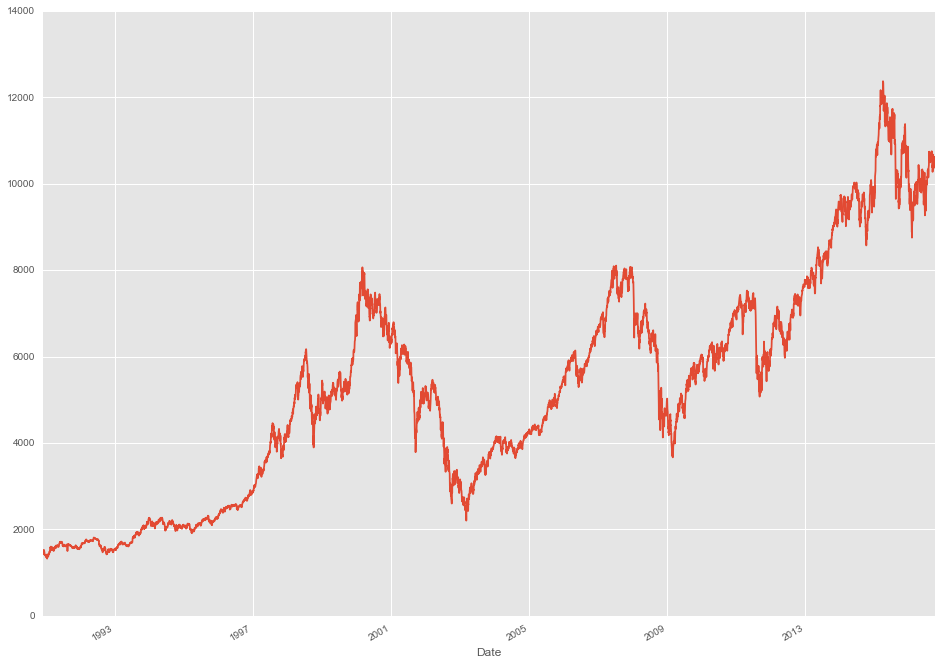

In [16]:
df['Close'].plot(figsize=(16, 12)) 

The first obvious thing to note, aside from the two giant dips at the tail end corresponding to the market crashes in 2003 and 2009, is that the data is clearly non-stationary. This makes sense for market data as it tends to go up in the long run more than it goes down. 



***Another tool to visualize the data is the seasonal_decompose function in statsmodel. With this, the trend,seasonality and residual factors become even more obvious.***

This is a problem for time series analysis though as non-stationary data is hard to reason about. 

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

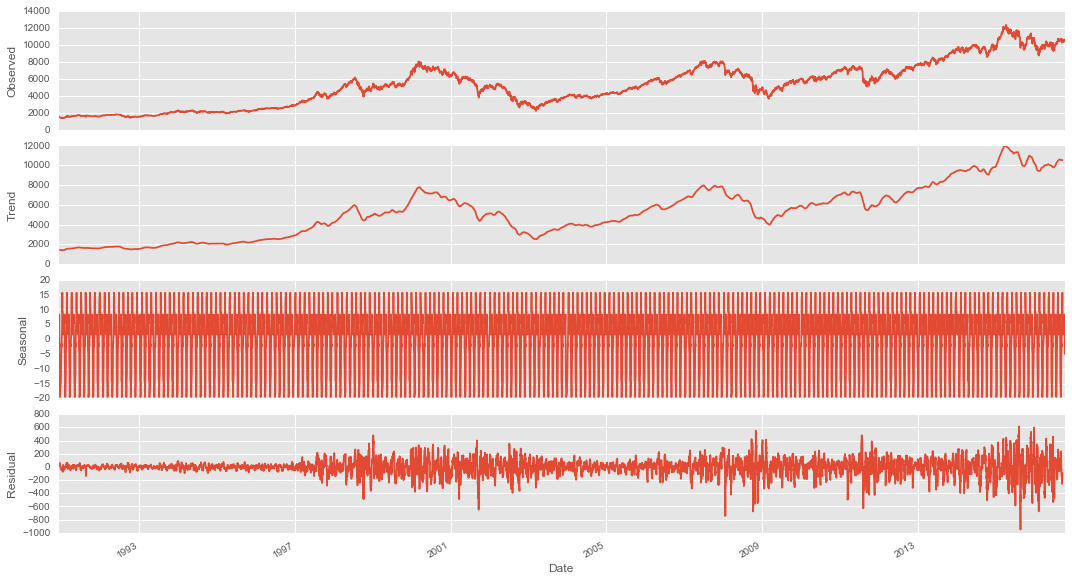

In [27]:
decomposition = seasonal_decompose(df.Close,model='additive', freq=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

Since we don't see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal pattern though it can be very useful. The folling instance, for example, is a sample from the statsmodels documentation showing CO2 emissions data over time.

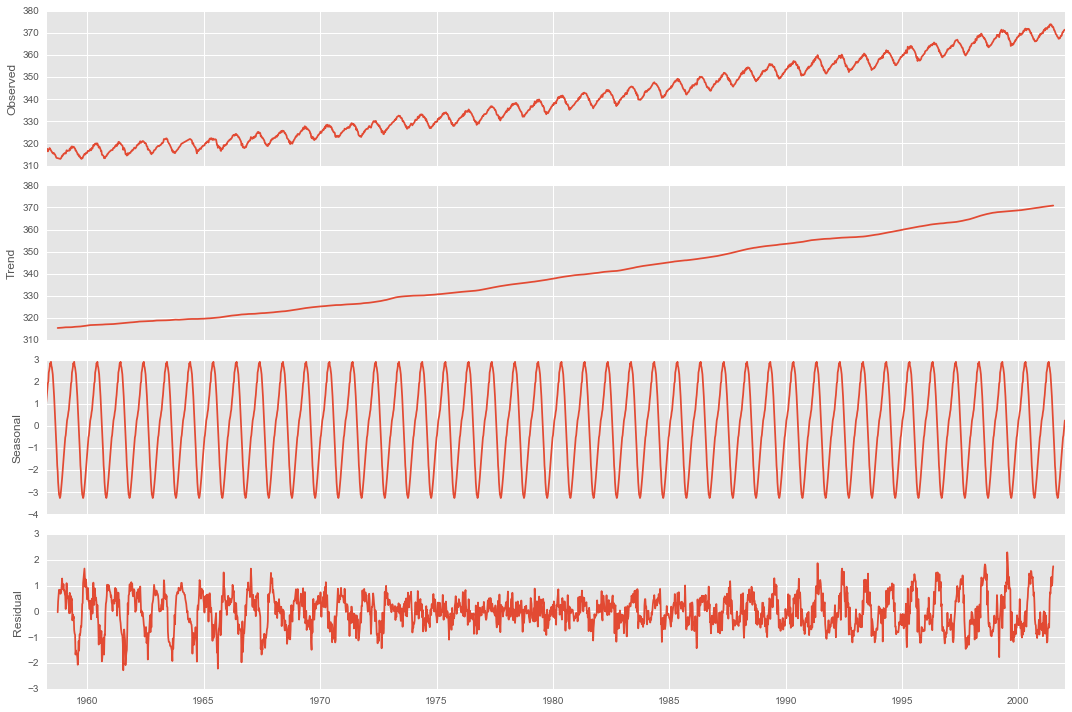

In [28]:
co2_data = sm.datasets.co2.load_pandas().data  
co2_data.co2.interpolate(inplace=True)  
result = sm.tsa.seasonal_decompose(co2_data.co2)  
fig = plt.figure()  
fig = result.plot()  

The decomposition is much more useful in this case. There are three clearly distinct components to the time series - a trend line, a seasonal adjustment, and residual values. Each of these would need to be accounted for and modeled appropriately.

You can actually access each component of the decomposition as such:

* trend = decomposition.trend
* seasonal = decomposition.seasonal 
* residual = decomposition.residual  

The residual values essentially take out the trend and seasonality of the data, making the values independent of time. You could try to model the residuals using exogenous variables, but it could be tricky to then try and convert the predicted residual values back into meaningful numbers.



### What does it mean for data to be stationary?

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. Constant mean :The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over ![time](http://www.seanabu.com/img/Mean_nonstationary.png). 
2. Constant variance:The variance of the series should not be a function of time. This property is known as homoscedasticity. Notice in the red graph the varying spread of data over ![time](http://www.seanabu.com/img/Var_nonstationary.png).
3. Autocovariance that does not depend on time :the covariance of the i th term and the (i + m) th term should not be a function of time. In the following graph, you will notice the spread becomes closer as the time increases. Hence, the covariance is not constant with time for the ![red series](http://www.seanabu.com/img/Cov_nonstationary.png).

Why is this important? When running a linear regression the assumption is that all of the observations are all independent of each other. In a time series, however, we know that observations are time dependent. It turns out that a lot of nice results that hold for independent random variables (law of large numbers and central limit theorem to name a couple) hold for stationary random variables. So by making the data stationary, we can actually apply regression techniques to this time dependent variable.

**Going Back to our dataset**

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:

1. Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

2. Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary.If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. For a more accurate assessment there is the [Dickey-Fuller test] (https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test). 

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
$$ Y_t = \rho * Y_{t-1} + \epsilon_t \\$$$$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t \\$$

We have to test if p – 1 is significantly different than zero or not. If the null hypothesis gets rejected, we’ll get a stationary time series.

We’ll be using the rolling statistics plots along with Dickey-Fuller test results a lot so I have defined a function which takes a TS as input and generated them for us. Please note that I’ve plotted standard deviation instead of variance to keep the unit similar to mean.

Below is code that will help you visualize the time series and test for stationarity. Following code is for a series and not a dtaframe.Specifically here: dftest = adfuller(timeseries.unstack(), autolag=’AIC’)
note the .unstack() that was added — transforming the df into a series.

In [281]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

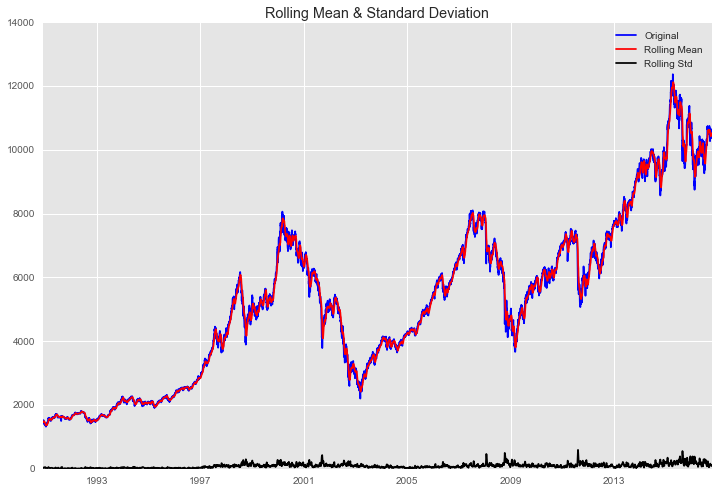

Results of Dickey-Fuller Test:
Test Statistic                   -0.776120
p-value                           0.826036
#Lags Used                        5.000000
Number of Observations Used    6549.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861981
Critical Value (10%)             -2.567005
dtype: float64


In [30]:
test_stationarity(df.Close)



Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. 

This tests the null hypothesis that Demand follows a unit root process. We usually reject the null when the p-value is less than or equal to a specified significance level, often 0.05 (5%), or 0.01 (1%) and even 0.1 (10%). Our approximate p-value is 0.826036, so we would fail to reject the null in all these cases, but that does not imply that the null hypothesis is true. The data are merely consistent with it.

The other way to see this is that our test statistic is smaller (in absolute value) than the 10% critical value. If we observed a test statistic like -4, then we could reject the null and claim that our variable is stationary. This might be more familiar way if we remember that we reject when the test statistic is "extreme". I find the absolute value thing a bit confusing, so I prefer to look at the p-value.

Some things to worry about and try:

1. You don't have any lags here. There are three schools of thought on how to choose the right number. One, is to use the frequency of the data to decide (4 lags for quarterly, 12 for monthly). Two, chose some number of lags that you are confident are larger than needed, and trim away the longest lag as long as it is insignificant, one-by-one. This is a stepwise approach and can lead you astray.
2. You also don't have a drift or a trend terms. If a graph of the data shows an upward trend over time, add the trend option. If there's no trend, but you have a nonzero mean, the default option you have is fine. It might help if you post a graph of the data.
**Note that the signed values should be compared and not the absolute values.**

### How to make a Time Series Stationary?

Actually, its almost impossible to make a series perfectly stationary, but we try to take it as close as possible.

Lets understand what is making a TS non-stationary. There are 3 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time.  A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. Sometimes we will refer to a trend “changing direction” when it might go from an increasing trend to a decreasing trend.For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week). Seasonality is always of a fixed and known period.eg people might have a tendency to buy cars in a particular month because of pay increment or [festivals](https://www.analyticsvidhya.com/blog/2016/10/tutorial-optimizing-neural-networks-using-keras-with-image-recognition-case-study/).

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.
3. Cyclic: A cyclic pattern exists when data exhibit rises and falls that are not of fixed period. The duration of these fluctuations is usually of at least 2 years.
$$ y_t=S_t+T_t+E_t \\$$
where $y_t$ is the data at period t, $S_t$ is the seasonal component at period 't', $T_t$ is the trend-cycle component at period tt and $E_t$ is the remainder (or irregular or error) component at period tt.
Alternatively, a multiplicative model would be written as
$$ y_t=S_t*T_t*E_t \\$$

The additive model is most appropriate if the magnitude of the seasonal fluctuations or the variation around the trend-cycle does not vary with the level of the time series. When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be proportional to the level of the time series, then a multiplicative model is more appropriate. With economic time series, multiplicative models are [common](https://github.com/piushvaish/TimeSeriesAnalysiswithPython/blob/master/time_series/5-Model.ipynb).

An alternative to using a multiplicative model, is to first transform the data until the variation in the series appears to be stable over time, and then use an additive model. When a log transformation has been used, this is equivalent to using a multiplicative decomposition because
$$ log y_t=log S_t+ log T_t + log E_t \\$$

Sometimes, the trend-cycle component is simply called the “trend” component, even though it may contain cyclic behaviour as well.So now we need to transform the data to make it more stationary. There are various transformations you can do to stationarize the data.

1. Deflation by CPI
2. Logarithmic
3. First Difference
4. Seasonal Difference
5. Seasonal Adjustment
You can read [more](http://people.duke.edu/~rnau/whatuse.htm).

Note: I’ll be discussing a number of methods. Some might work well in this case and others might not. But the idea is to get a hang of all the methods and not focus on just the problem at hand.

Let’s start by working on the trend part.



### Estimating & Eliminating Trend

One of the first tricks to reduce trend can be transformation. For example, in this case we can clearly see that the there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

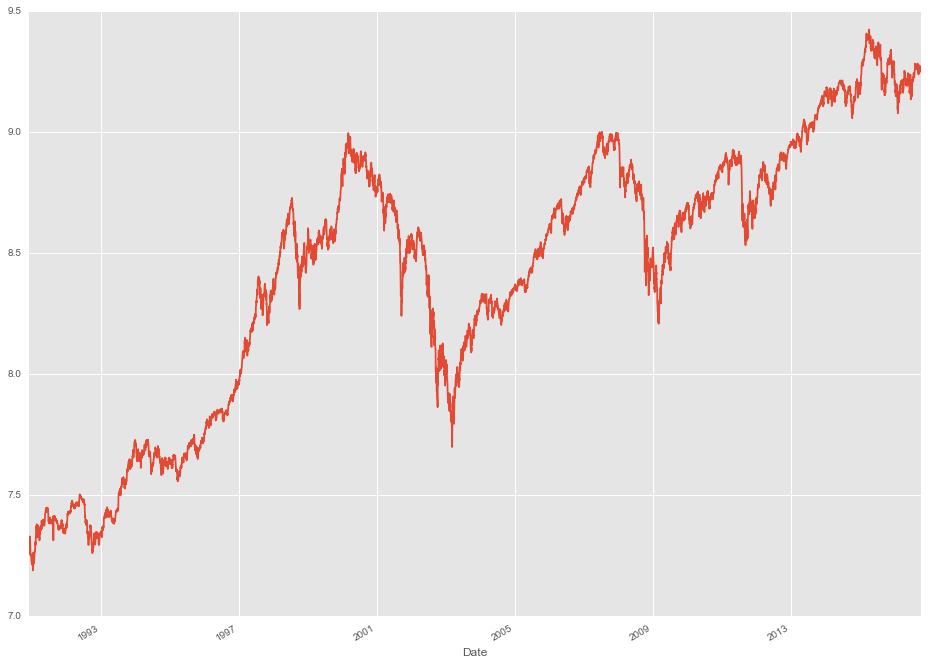

In [31]:
df['Natural_Log'] = df['Close'].apply(lambda x: np.log(x))  
df['Natural_Log'].plot(figsize=(16, 12))   


So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve. 

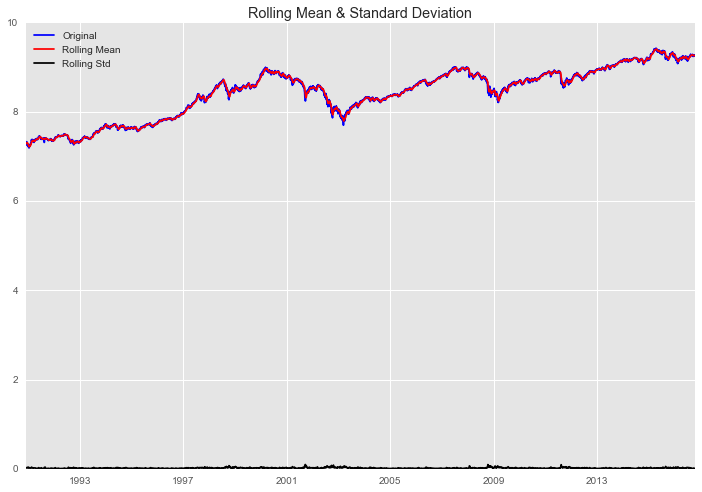

Results of Dickey-Fuller Test:
Test Statistic                   -1.460622
p-value                           0.552894
#Lags Used                        5.000000
Number of Observations Used    6549.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861981
Critical Value (10%)             -2.567005
dtype: float64


In [32]:
test_stationarity(df['Natural_Log'])

One way to visually see the effect that the log transform had is to analyze the variance over time. We can use a rolling variance statistic and compare both the original series and the logged series.

In [189]:
df['Original Variance'] = pd.rolling_var(df['Close'], 30, min_periods=None, freq=None, center=True)  
df['Log Variance'] = pd.rolling_var(df['Natural_Log'], 30, min_periods=None, freq=None, center=True)


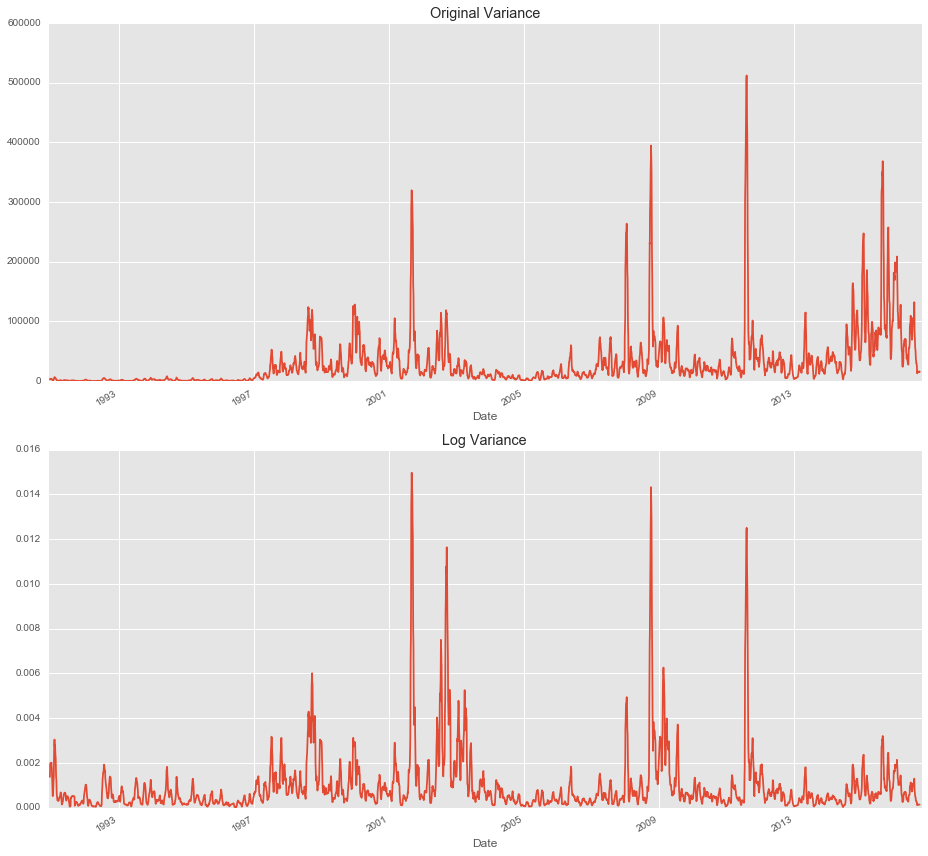

In [190]:
fig, ax = plt.subplots(2, 1, figsize=(13, 12))  
df['Original Variance'].plot(ax=ax[0], title='Original Variance')  
df['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

Observe that in the top graph, we can't even see any of the variations until the late 90s. In the bottom graph however it's a different story, changes in the value are clearly visible throughout the entire data set. From this view, it's clear that our transformation has made the variance relatively constant.

Now we can see the earlier variations in the data set quite a bit better than before. 

#### Another way to visualise

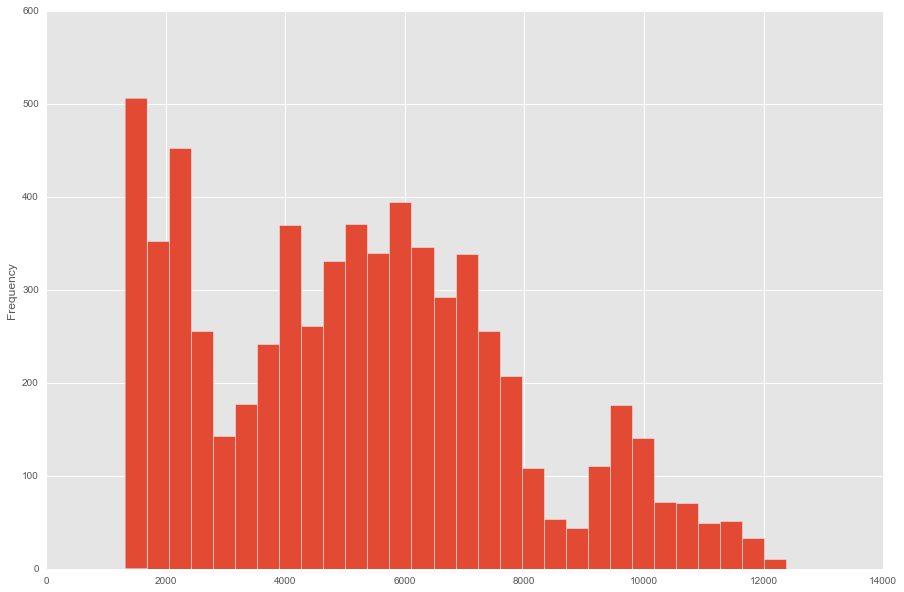

In [33]:
df.Close.plot(kind = "hist",bins = 30)

In [40]:
df.head(3)

Open         High          Low        Close  Volume  \
Date                                                                     
1990-11-26  1466.300049  1466.300049  1443.199951  1443.199951       0   
1990-11-27  1438.300049  1438.300049  1415.300049  1415.300049       0   
1990-11-28  1410.000000  1431.900024  1402.800049  1420.599976       0   

              Adj Close  Natural_Log  closing_Mean  
Date                                                
1990-11-26  1443.199951     7.274618   4555.538412  
1990-11-27  1415.300049     7.255097   4555.538412  
1990-11-28  1420.599976     7.258835   4555.538412

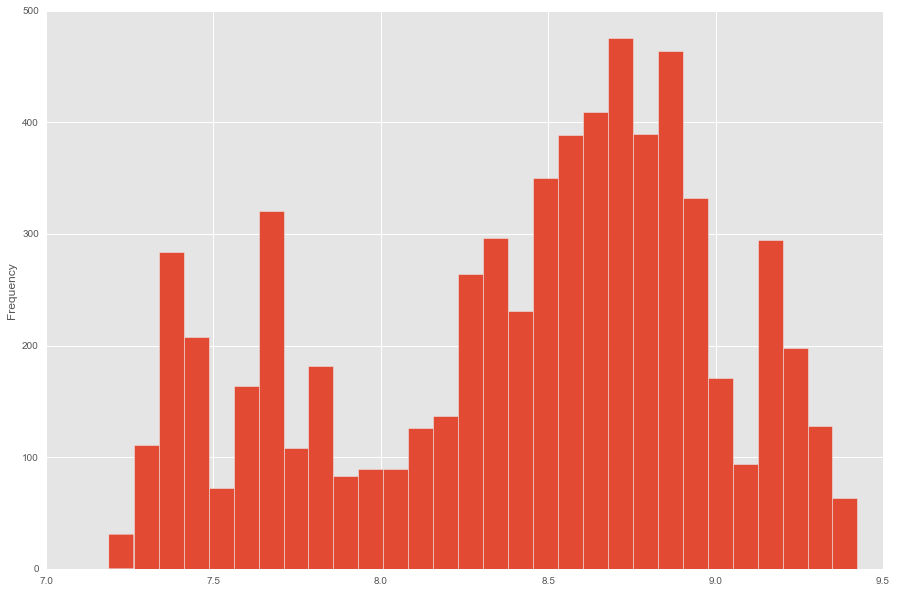

In [35]:
df.Natural_Log.plot(kind = "hist", bins = 30)

In this simpler case, it is easy to see a forward trend in the data. But its not very intuitive in presence of noise. So we can use some techniques to estimate or model this trend and then remove it from the series. There can be many ways of doing it and some of most commonly used are:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model


### Basic Time Series Model
We will build a time-series forecasting model to get a forecast closing prices. 

Let us start with the three most basic models -
1. Mean Constant Model
2. Linear Trend Model
3. Random Walk Model
********

**Mean Model**

This very simple forecasting model will be called the "mean model"

In [36]:
model_mean_pred = df.Natural_Log.mean()

In [37]:
# Let us store this as our Mean Predication Value
df["closing_Mean"] = np.exp(model_mean_pred)

#### Can we measure the error rate?
We will use Root Mean Squared Error (RMSE) to calculate our error values

In [38]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [39]:
model_mean_RMSE = RMSE(df.closing_Mean, df.Close)
model_mean_RMSE

2690.4535330002723

In [41]:
# Save this in a dataframe
dfResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
dfResults.head()

Empty DataFrame
Columns: [Model, Forecast, RMSE]
Index: []

In [43]:
dfResults.loc[0,"Model"] = "Mean"
dfResults.loc[0,"Forecast"] = np.exp(model_mean_pred)
dfResults.loc[0,"RMSE"] = model_mean_RMSE
dfResults.head()

Model Forecast     RMSE
0  Mean  4555.54  2690.45

#### Linear Trend Model
Let us start by plotting a linear trend model between Natural_Log and time.

However to do linear regression, we need a numeric indicator for time period - 

Let us create that.

In [44]:
df.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Adj Close       float64
Natural_Log     float64
closing_Mean    float64
dtype: object

In [46]:
# What is the starting month of our data
df.index.min()

Timestamp('1990-11-26 00:00:00')

In [48]:
# Convert date in datetimedelta figure starting from zero
df["timeIndex"] = df.index - df.index.min()

In [49]:
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
1990-11-26  1466.300049  1466.300049  1443.199951  1443.199951       0   
1990-11-27  1438.300049  1438.300049  1415.300049  1415.300049       0   
1990-11-28  1410.000000  1431.900024  1402.800049  1420.599976       0   
1990-11-29  1420.400024  1424.599976  1415.800049  1418.900024       0   
1990-11-30  1421.500000  1443.900024  1421.500000  1441.199951       0   

              Adj Close  Natural_Log  closing_Mean  timeIndex  
Date                                                           
1990-11-26  1443.199951     7.274618   4555.538412     0 days  
1990-11-27  1415.300049     7.255097   4555.538412     1 days  
1990-11-28  1420.599976     7.258835   4555.538412     2 days  
1990-11-29  1418.900024     7.257637   4555.538412     3 days  
1990-11-30  1441.199951     7.273231   4555.538412     4 days

In [50]:
df.dtypes

Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                    int64
Adj Close               float64
Natural_Log             float64
closing_Mean            float64
timeIndex       timedelta64[ns]
dtype: object

In [51]:
# Convert to months using the timedelta function
df["timeIndex"] =  df["timeIndex"]/np.timedelta64(1, 'M')

In [53]:
# Round the number to 0
df["timeIndex"] = df["timeIndex"].round(0).astype(int)

In [54]:
df.timeIndex.tail()

Date
2016-10-07    310
2016-10-10    310
2016-10-11    311
2016-10-12    311
2016-10-13    311
Name: timeIndex, dtype: int32

In [55]:
## Now plot linear regression between priceMod and timeIndex
model_linear = smf.ols('Natural_Log ~ timeIndex', data = df).fit()

In [56]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Natural_Log   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                 2.195e+04
Date:                Fri, 14 Oct 2016   Prob (F-statistic):               0.00
Time:                        10:59:05   Log-Likelihood:                -740.22
No. Observations:                6555   AIC:                             1484.
Df Residuals:                    6553   BIC:                             1498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.5601      0.007   1124.402      0.000         7.547     7.573
timeIndex      0.0055   3.74e-05    148.146      0.000         0.005     0.006
==============================================================================
Omnibus:                      572.333   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              734.123
Skew:                           0.817   Prob(JB):                    3.87e-160
Kurtosis:                       3.122   Cond. No.                         361.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
## Parameters for y = mx + c equation
model_linear.params

Intercept    7.560148
timeIndex    0.005539
dtype: float64

In [58]:
c = model_linear.params[0]
c

7.5601479909791278

In [59]:
m = model_linear.params[1]
m

0.0055394259633381564

In [60]:
model_linear_pred = model_linear.predict()

In [61]:
model_linear_pred

array([ 7.56014799,  7.56014799,  7.56014799, ...,  9.28290947,
        9.28290947,  9.28290947])

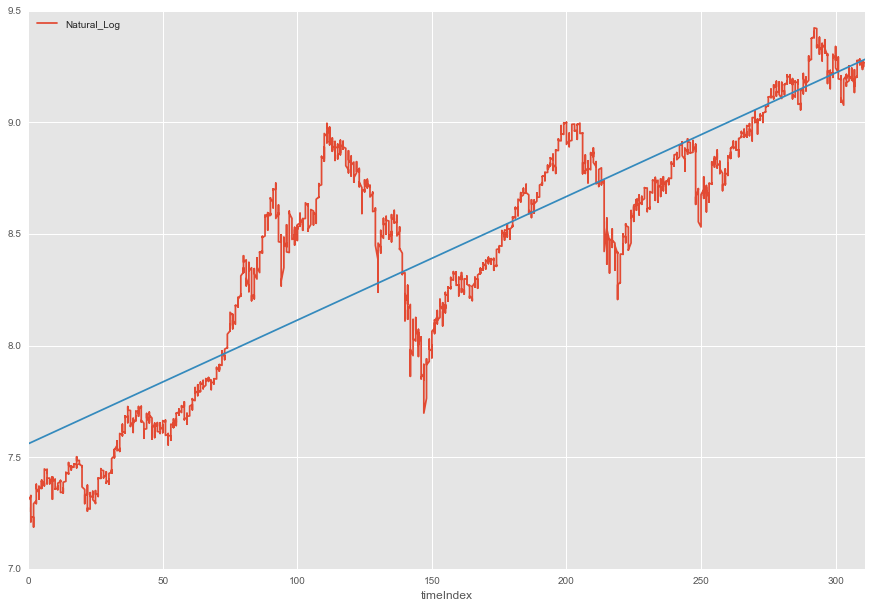

In [62]:
# Plot the prediction line
df.plot(kind="line", x="timeIndex", y = "Natural_Log")
plt.plot(df.timeIndex,model_linear_pred, '-')

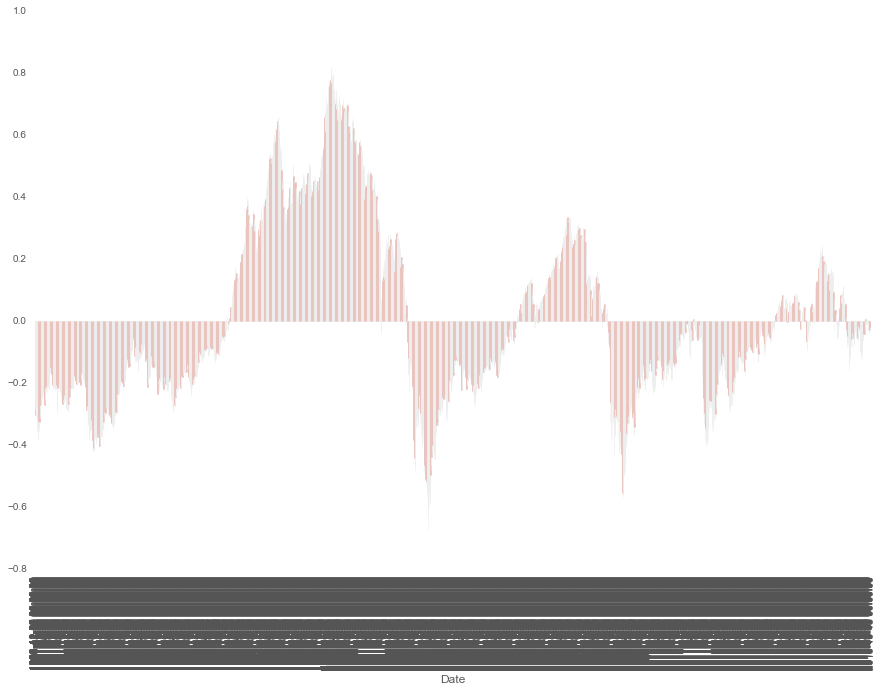

In [63]:
model_linear.resid.plot(kind = "bar")

#### Is this a good model?

What measures can we check to see if the model is good?

It is seen here (and also evident on the regression line plot, if you look closely) that the linear trend model has a tendency to make an error of the same sign for many periods in a row. 

***This tendency is measured in statistical terms by the lag-1 autocorrelation and Durbin-Watson statistic.***

If there is no time pattern, the lag-1 autocorrelation should be very close to zero, and the Durbin-Watson statistic ought to be very close to 2, which is not the case here. If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.

In [65]:
# Manual Calculation
##6555 is the number of observations
model_linear_forecast_manual = m * 6555 + c
model_linear_forecast_manual

43.871085180660742

In [66]:
# Using Predict Function
model_linear_forecast_auto = model_linear.predict(exog = dict(timeIndex=146))
model_linear_forecast_auto

array([ 8.36890418])

In [67]:
df["priceLinear"] = np.exp(model_linear_pred)

In [68]:
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
1990-11-26  1466.300049  1466.300049  1443.199951  1443.199951       0   
1990-11-27  1438.300049  1438.300049  1415.300049  1415.300049       0   
1990-11-28  1410.000000  1431.900024  1402.800049  1420.599976       0   
1990-11-29  1420.400024  1424.599976  1415.800049  1418.900024       0   
1990-11-30  1421.500000  1443.900024  1421.500000  1441.199951       0   

              Adj Close  Natural_Log  closing_Mean  timeIndex  priceLinear  
Date                                                                        
1990-11-26  1443.199951     7.274618   4555.538412          0  1920.129654  
1990-11-27  1415.300049     7.255097   4555.538412          0  1920.129654  
1990-11-28  1420.599976     7.258835   4555.538412          0  1920.129654  
1990-11-29  1418.900024     7.257637   4555.538412          0  1920.129654  
1990-11-30  1441.199951     7.273231   4555.538412          0  1920.129654

In [69]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(df.priceLinear, df.Close)
model_linear_RMSE

1282.5078743651038

In [70]:
dfResults.loc[1,"Model"] = "Linear"
dfResults.loc[1,"Forecast"] = np.exp(model_linear_forecast_manual)
dfResults.loc[1,"RMSE"] = model_linear_RMSE
dfResults.head()

Model     Forecast     RMSE
0    Mean      4555.54  2690.45
1  Linear  1.12972e+19  1282.51

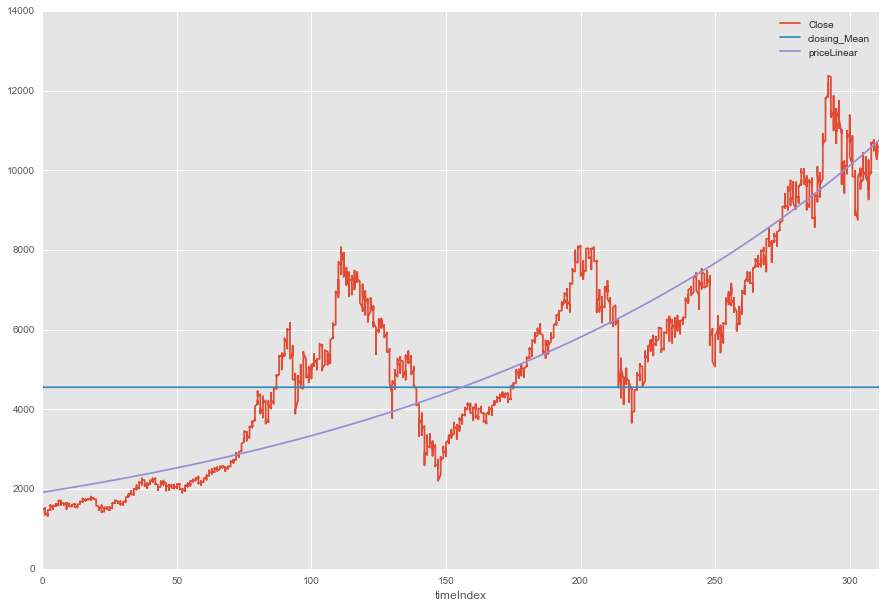

In [72]:
df.plot(kind="line", x="timeIndex", y = ["Close", "closing_Mean", "priceLinear"])

#### Linear Model with Regressor

In [75]:
## Now plot linear regression between priceMod and timeIndex
model_linear_opening = smf.ols('Natural_Log ~ timeIndex + np.log(Open)', data = df).fit()

In [76]:
model_linear_opening.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Natural_Log   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.819e+06
Date:                Fri, 14 Oct 2016   Prob (F-statistic):               0.00
Time:                        11:12:51   Log-Likelihood:                 19486.
No. Observations:                6555   AIC:                        -3.897e+04
Df Residuals:                    6552   BIC:                        -3.895e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        0.0111      0.004      2.592      0.010         0.003     0.019
timeIndex     8.755e-06   3.56e-06      2.458      0.014      1.77e-06  1.57e-05
np.log(Open)     0.9985      0.001   1769.370      0.000         0.997     1.000
==============================================================================
Omnibus:                      808.357   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9096.073
Skew:                           0.029   Prob(JB):                         0.00
Kurtosis:                       8.771   Cond. No.                     5.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
df["closing_Linear_opening"] = np.exp(model_linear_opening.predict())

In [84]:
df.dtypes

Open                      float64
High                      float64
Low                       float64
Close                     float64
Volume                      int64
Adj Close                 float64
Natural_Log               float64
closing_Mean              float64
timeIndex                   int32
priceLinear               float64
closing_Linear_openimg    float64
closing_Linear_opening    float64
dtype: object

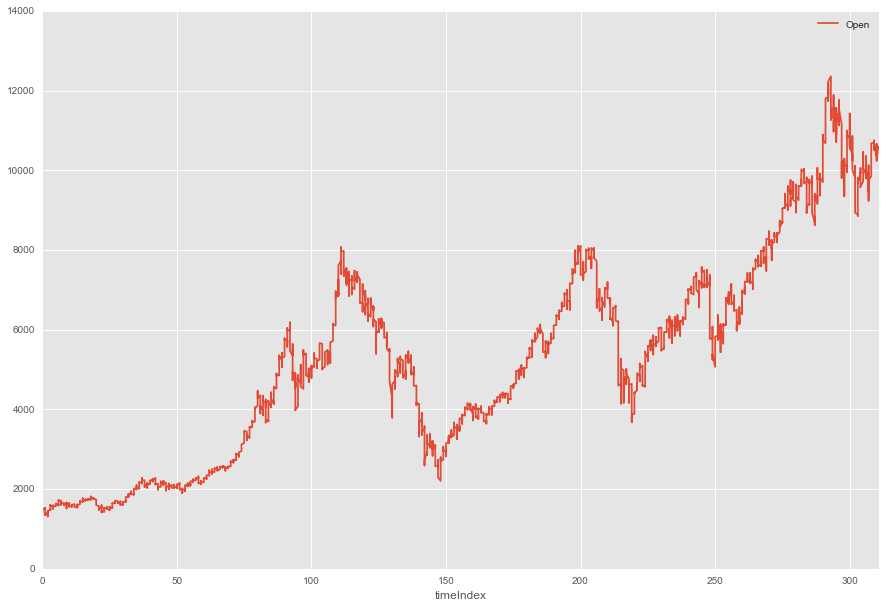

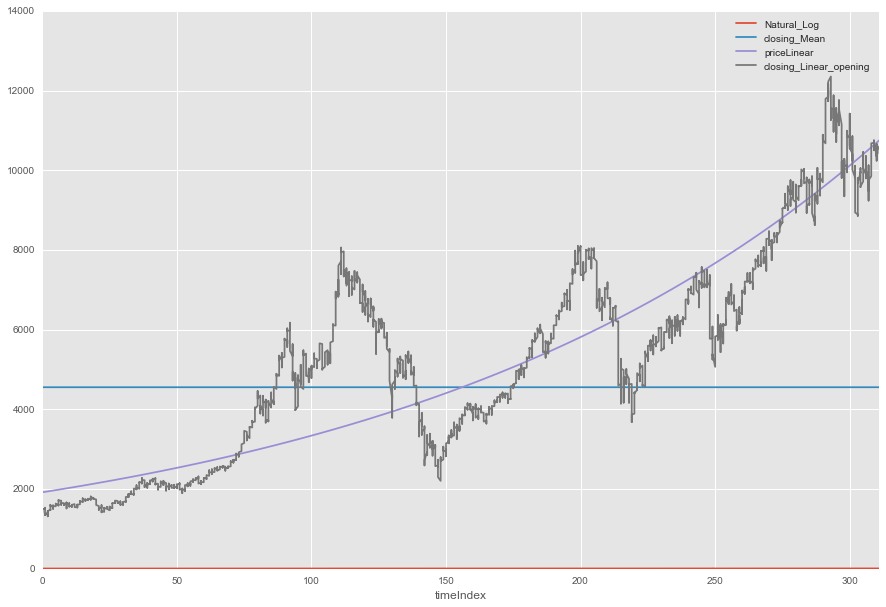

In [87]:
df.plot(kind = "line", x="timeIndex", y = "Open")
df.plot(kind="line", x="timeIndex", y = ["Natural_Log", "closing_Mean", 
                                             "priceLinear", "closing_Linear_opening"])

####  Simple Moving average

As a first step in moving beyond mean models, random walk model and linear trend models, nonseasonal patterns and trends can be extrapolated using a moving-average or smoothing model. The basic assumption behind averaging and smoothing models is that the time series is locally stationary with a slowly varying mean. Hence, we take a moving (local) average to estimate the current value of the mean and then use that as the forecast for the near future. This can be considered as a compromise between the mean model and the random-walk-without-drift-model. The same strategy can be used to estimate and extrapolate a local trend. A moving average is often called a "smoothed" version of the original series because short-term averaging has the effect of smoothing out the bumps in the original series. By adjusting the degree of smoothing (the width of the moving average), we can hope to strike some kind of optimal balance between the performance of the mean and random walk models.
Simple Moving Average (SMA)
$$ \hat{y_t} = \frac{y_{t-1} + y_{t-2} + y_{t-3} + ... + y_{t-m}}{m} \\$$

In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values. Pandas has specific functions defined for determining rolling statistics.


In [121]:
df_close = df['Close']

In [122]:
df_close.head()

Date
1990-11-26    1443.199951
1990-11-27    1415.300049
1990-11-28    1420.599976
1990-11-29    1418.900024
1990-11-30    1441.199951
Name: Close, dtype: float64

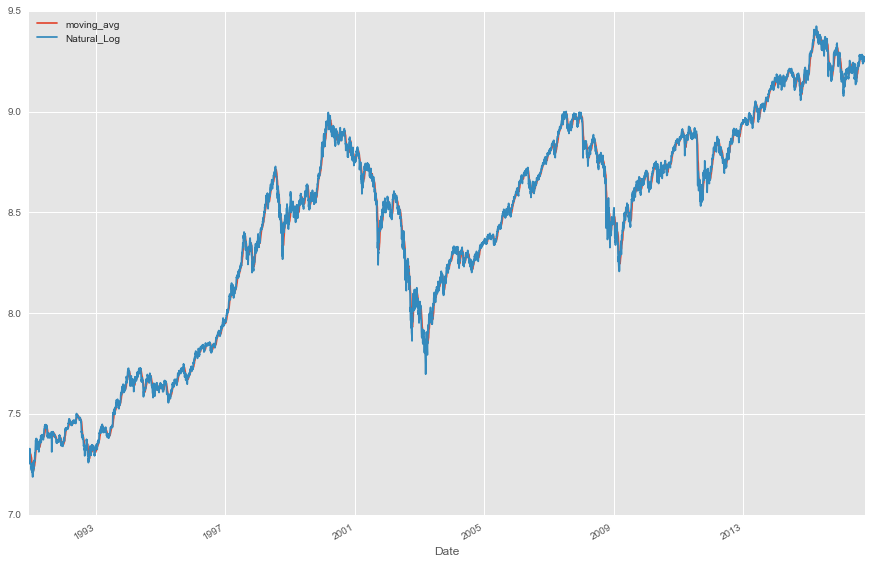

In [162]:
# This is unneccasry..df_log is same as Natural_log
df_log = np.log(df_close)
df['moving_avg'] = pd.rolling_mean(df_log,window = 12)
df.plot(kind ="line", y=["moving_avg",'Natural_Log'])

The long-term forecasts from the SMA model are not a horizontal straight line, just as in the random walk model. Thus, the SMA model assumes that there is trend in the data.
*****
However, whereas the forecasts from the random walk model are simply equal to the last observed value, the forecasts from the SMA model are equal to a weighted average of recent values.



In [163]:
df["CloseMA12"] = np.exp(df.moving_avg)
df.tail()

Open          High           Low         Close     Volume  \
Date                                                                            
2016-10-07  10549.690430  10579.089844  10465.349609  10490.860352  121513900   
2016-10-10  10496.009766  10639.410156  10454.980469  10624.080078   98623700   
2016-10-11  10600.940430  10692.360352  10568.719727  10577.160156   95044500   
2016-10-12  10572.719727  10604.000000  10503.200195  10523.070312   87689500   
2016-10-13  10425.790039  10430.830078  10349.059570  10414.070312   95793600   

               Adj Close  Natural_Log  closing_Mean  timeIndex   priceLinear  \
Date                                                                           
2016-10-07  10490.860352     9.258260   4555.538412        310  10693.272021   
2016-10-10  10624.080078     9.270878   4555.538412        310  10693.272021   
2016-10-11  10577.160156     9.266452   4555.538412        311  10752.670976   
2016-10-12  10523.070312     9.261325   4555.538412        311  10752.670976   
2016-10-13  10414.070312     9.250913   4555.538412        311  10752.670976   

            closing_Linear_opening  Natural_Log_Shift1  Natural_LogDiff  \
Date                                                                      
2016-10-07            10549.074043            9.265662        -0.007402   
2016-10-10            10495.476627            9.258260         0.012619   
2016-10-11            10600.336986            9.270878        -0.004426   
2016-10-12            10572.160057            9.266452        -0.005127   
2016-10-13            10425.456449            9.261325        -0.010412   

            Close_Random  moving_avg     CloseMA12  
Date                                                
2016-10-07  10568.799805    9.259980  10508.925915  
2016-10-10  10490.860352    9.261465  10524.538693  
2016-10-11  10624.080078    9.260704  10516.533672  
2016-10-12  10577.160156    9.259885  10507.926728  
2016-10-13  10523.070312    9.260048  10509.640530

In [164]:
model_MA12_forecast = df.Natural_Log.tail(12).mean()

In [166]:
# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(df.CloseMA12, df.Natural_Log)
model_MA12_RMSE

5849.8394530739251

In [167]:
dfResults.loc[3,"Model"] = "Moving Average 12"
dfResults.loc[3,"Forecast"] = np.exp(model_MA12_forecast)
dfResults.loc[3,"RMSE"] = model_MA12_RMSE
dfResults.head()

Model     Forecast     RMSE
0               Mean      4555.54  2690.45
1             Linear  1.12972e+19  1282.51
2             Random      10523.1  79.9749
3  Moving Average 12      10509.6  5849.84

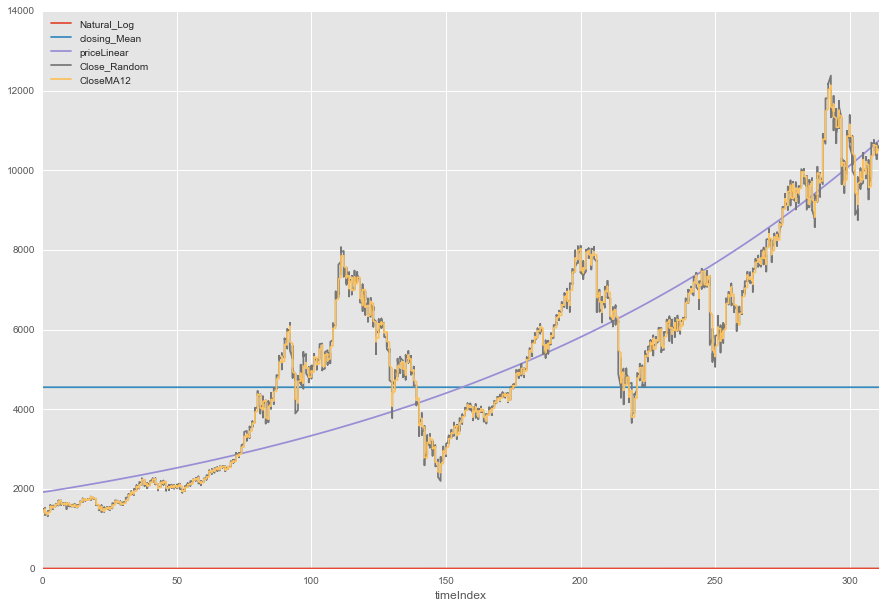

In [274]:
df.plot(kind="line", x="timeIndex", y = ["Natural_Log", "closing_Mean", "priceLinear",
                                             "Close_Random", "CloseMA12"])

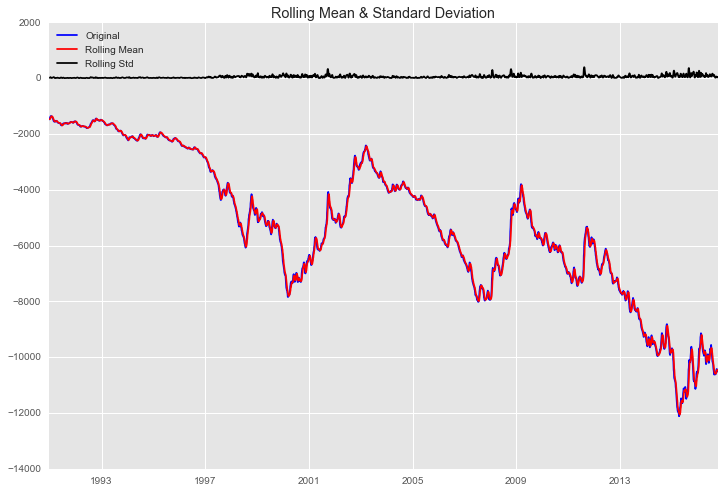

Results of Dickey-Fuller Test:
Test Statistic                   -0.659537
p-value                           0.856954
#Lags Used                       34.000000
Number of Observations Used    6509.000000
Critical Value (1%)              -3.431355
Critical Value (5%)              -2.861984
Critical Value (10%)             -2.567006
dtype: float64


In [275]:
# Test remaining part for Stationary
ts = df.Natural_Log - df.CloseMA12
ts.dropna(inplace = True)
test_stationarity(ts)

#### Simple Exponential Smoothing Model (SES)
Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha
$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} \\$$

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. This can be observed as:

In [173]:
df['Natural_LogExp12'] = pd.ewma(df.Natural_Log, halflife=12)

In [174]:
halflife = 12
alpha = 1 - np.exp(np.log(0.5)/halflife)
alpha

0.056125687318306472

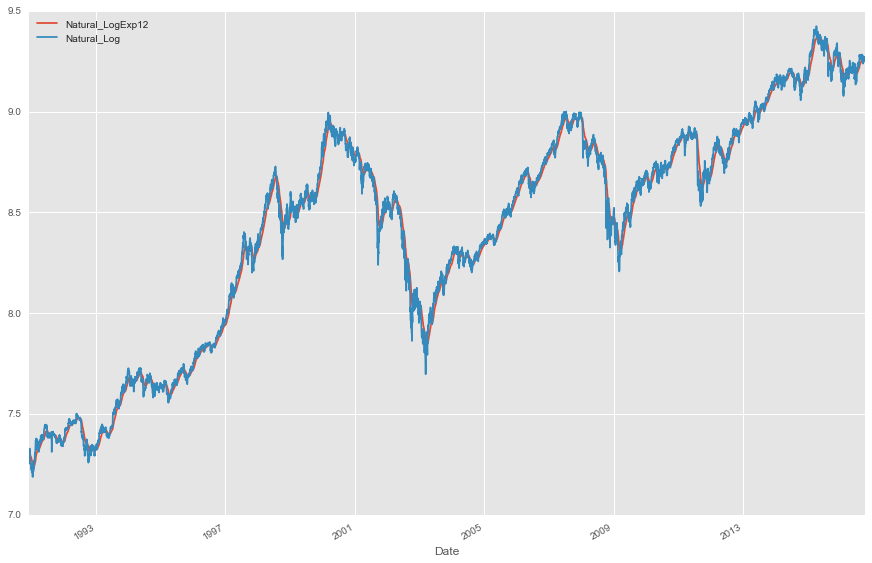

In [175]:
df.plot(kind ="line", y=["Natural_LogExp12", "Natural_Log"])

In [176]:
df["Close_Exp12"] = np.exp(df.Natural_LogExp12)
df.tail()

Open          High           Low         Close     Volume  \
Date                                                                            
2016-10-07  10549.690430  10579.089844  10465.349609  10490.860352  121513900   
2016-10-10  10496.009766  10639.410156  10454.980469  10624.080078   98623700   
2016-10-11  10600.940430  10692.360352  10568.719727  10577.160156   95044500   
2016-10-12  10572.719727  10604.000000  10503.200195  10523.070312   87689500   
2016-10-13  10425.790039  10430.830078  10349.059570  10414.070312   95793600   

               Adj Close  Natural_Log  closing_Mean  timeIndex   priceLinear  \
Date                                                                           
2016-10-07  10490.860352     9.258260   4555.538412        310  10693.272021   
2016-10-10  10624.080078     9.270878   4555.538412        310  10693.272021   
2016-10-11  10577.160156     9.266452   4555.538412        311  10752.670976   
2016-10-12  10523.070312     9.261325   4555.538412        311  10752.670976   
2016-10-13  10414.070312     9.250913   4555.538412        311  10752.670976   

            closing_Linear_opening  Natural_Log_Shift1  Natural_LogDiff  \
Date                                                                      
2016-10-07            10549.074043            9.265662        -0.007402   
2016-10-10            10495.476627            9.258260         0.012619   
2016-10-11            10600.336986            9.270878        -0.004426   
2016-10-12            10572.160057            9.266452        -0.005127   
2016-10-13            10425.456449            9.261325        -0.010412   

            Close_Random  moving_avg     CloseMA12  Natural_LogExp12  \
Date                                                                   
2016-10-07  10568.799805    9.259980  10508.925915          9.257361   
2016-10-10  10490.860352    9.261465  10524.538693          9.258120   
2016-10-11  10624.080078    9.260704  10516.533672          9.258587   
2016-10-12  10577.160156    9.259885  10507.926728          9.258741   
2016-10-13  10523.070312    9.260048  10509.640530          9.258302   

             Close_Exp12  
Date                      
2016-10-07  10481.436458  
2016-10-10  10489.391458  
2016-10-11  10494.298189  
2016-10-12  10495.910959  
2016-10-13  10491.300607

In [177]:
# Root Mean Squared Error (RMSE)
model_Exp12_RMSE = RMSE(df.Close_Exp12, df.Natural_Log)
model_Exp12_RMSE

5822.626089660188

In [178]:
y_exp = df.Natural_Log[-1]
y_exp

9.250913085380482

In [179]:
y_for = df.Close_Exp12[-1]
y_for

10491.300607249619

In [180]:
model_Exp12_forecast = alpha * y_exp + (1 - alpha) * y_for

In [182]:
dfResults.loc[4,"Model"] = "Exp Smoothing 12"
dfResults.loc[4,"Forecast"] = np.exp(model_Exp12_forecast)
dfResults.loc[4,"RMSE"] = model_Exp12_RMSE
dfResults.head()

Model     Forecast     RMSE
0               Mean      4555.54  2690.45
1             Linear  1.12972e+19  1282.51
2             Random      10523.1  79.9749
3  Moving Average 12      10509.6  5849.84
4   Exp Smoothing 12          inf  5822.63

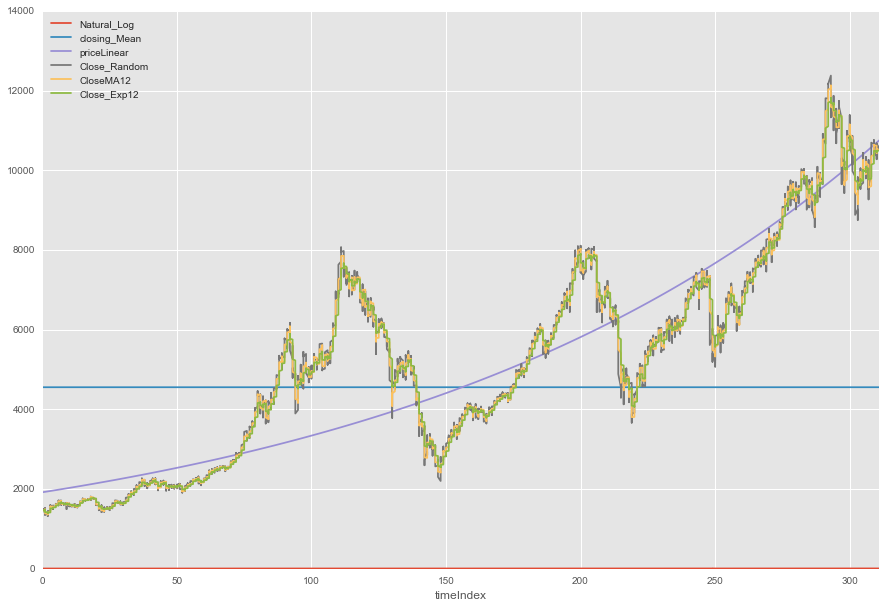

In [183]:
df.plot(kind="line", x="timeIndex", y = ["Natural_Log", "closing_Mean", "priceLinear",
                                             "Close_Random", "CloseMA12","Close_Exp12"])

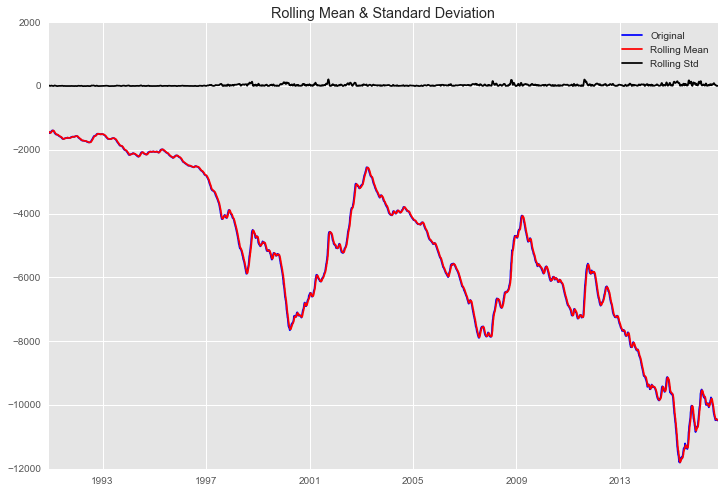

Results of Dickey-Fuller Test:
Test Statistic                   -0.826054
p-value                           0.811349
#Lags Used                        6.000000
Number of Observations Used    6548.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861982
Critical Value (10%)             -2.567005
dtype: float64


In [184]:
# Test remaining part for Stationary
ts = df.Natural_Log - df.Close_Exp12
ts.dropna(inplace = True)
test_stationarity(ts)


In [124]:
df_log_moving_avg_diff = df_log - moving_avg
df_log_moving_avg_diff.head(15)

Date
1990-11-26         NaN
1990-11-27         NaN
1990-11-28         NaN
1990-11-29         NaN
1990-11-30         NaN
1990-12-03         NaN
1990-12-04         NaN
1990-12-05         NaN
1990-12-06         NaN
1990-12-07         NaN
1990-12-10         NaN
1990-12-11    0.021619
1990-12-12    0.033732
1990-12-13    0.028301
1990-12-14    0.025559
Name: Close, dtype: float64

Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.

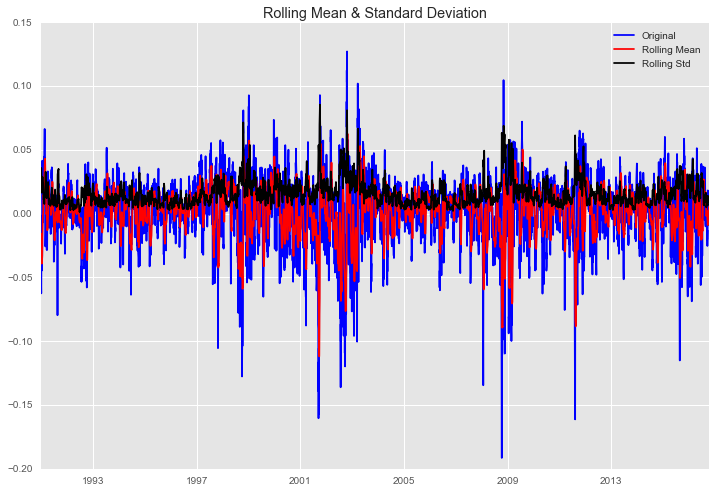

Results of Dickey-Fuller Test:
Test Statistic                -1.792626e+01
p-value                        2.894072e-30
#Lags Used                     1.100000e+01
Number of Observations Used    6.532000e+03
Critical Value (1%)           -3.431352e+00
Critical Value (5%)           -2.861983e+00
Critical Value (10%)          -2.567006e+00
dtype: float64


In [129]:
df_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(df_log_moving_avg_diff)


This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. 

So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a [decay factor](http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions). 

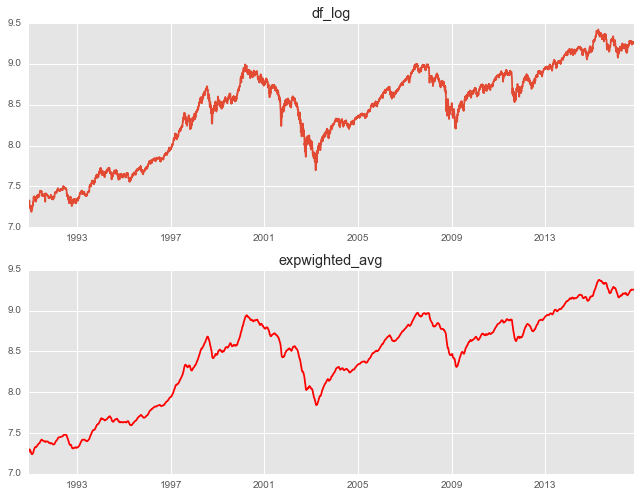

In [132]:
expwighted_avg = pd.ewma(df_log, halflife=12)
fig = plt.figure(2, figsize=(9, 7))
plt.subplot(211)
plt.plot(df_log)
plt.title('df_log')

plt.subplot(212)
plt.plot(expwighted_avg, color='red')
plt.title('expwighted_avg')
plt.tight_layout()

Note that here the parameter ‘halflife’ is used to define the amount of exponential decay. This is just an assumption here and would depend largely on the business domain. Other parameters like span and center of mass can also be used to define decay which are discussed in the link shared above. Now, let’s remove this from series and check stationarity:

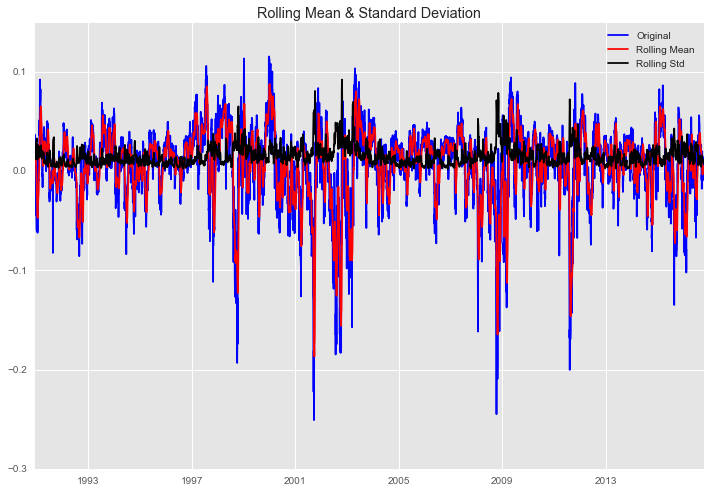

Results of Dickey-Fuller Test:
Test Statistic                -1.275302e+01
p-value                        8.454552e-24
#Lags Used                     5.000000e+00
Number of Observations Used    6.549000e+03
Critical Value (1%)           -3.431349e+00
Critical Value (5%)           -2.861981e+00
Critical Value (10%)          -2.567005e+00
dtype: float64


In [127]:
df_log_ewma_diff = df_log - expwighted_avg
##test_stationarity works with only one feature
test_stationarity(df_log_ewma_diff)

This time series has more variation in mean and standard deviation in magnitude. Also, the test statistics is ***bigger than the 1% critical value *** , which is not better than the previous case.

However,note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

#### Random Walk Model

When faced with a time series that shows irregular growth, the best strategy may not be to try to directly predict the level of the series at each period (i.e., the quantity Yt). Instead, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1). That is, it may be better to look at the first difference of the series, to see if a predictable pattern can be found there. For purposes of one-period-ahead forecasting, it is just as good to predict the next change as to predict the next level of the series, since the predicted change can be added to the current level to yield a predicted level. The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.

Random Walk Model $$ \hat{Y_t} = Y_{t-1} + \epsilon \\$$
Random Walk Model with drift $$ \hat{Y_t} = Y_{t-1} + c + \epsilon \\$$

In [138]:
df["Natural_Log_Shift1"] = df.Natural_Log.shift()

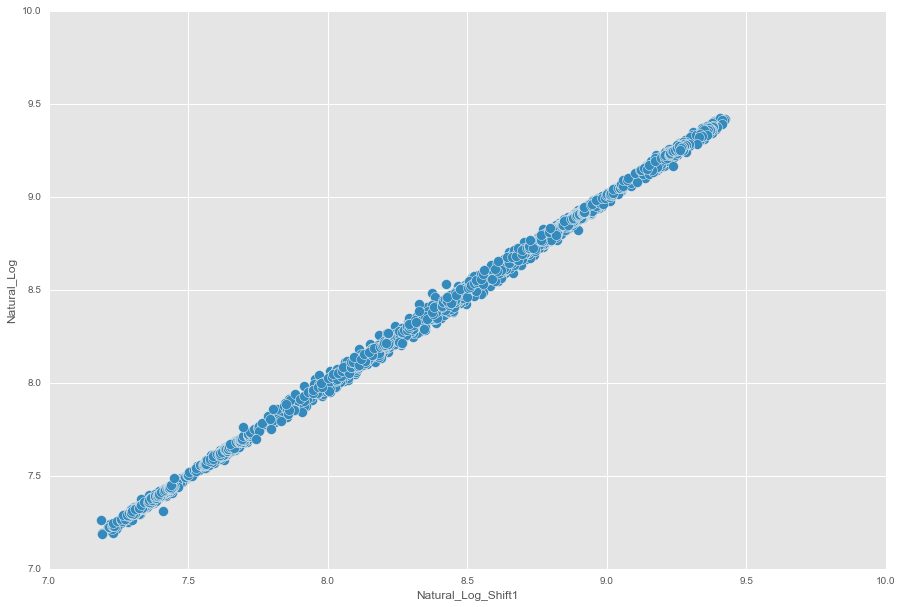

In [142]:
df.plot(kind= "scatter", y = "Natural_Log", x = "Natural_Log_Shift1", s = 100)

In [143]:
# Lets plot the one-month difference curve
df["Natural_LogDiff"] = df.Natural_Log - df.Natural_Log_Shift1

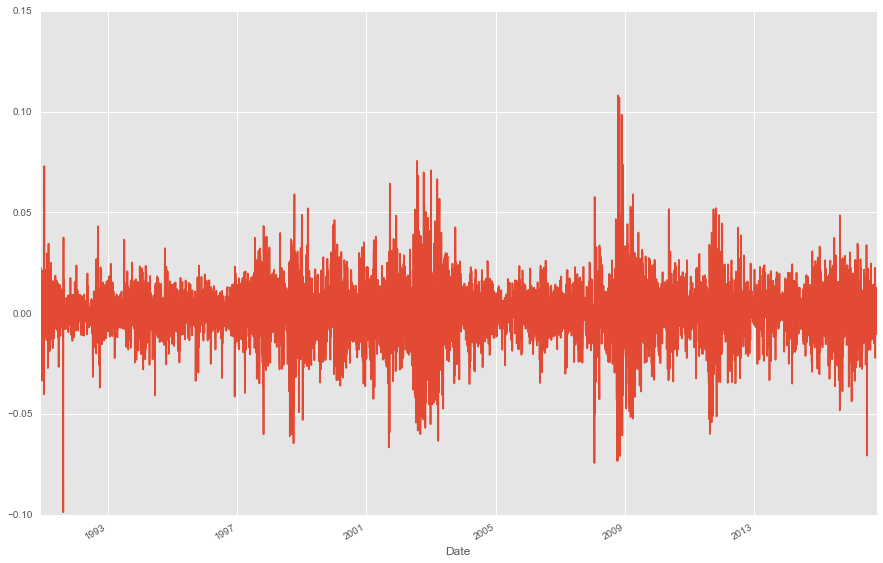

In [144]:
df.Natural_LogDiff.plot()

In [150]:
df["Close_Random"] = np.exp(df.Natural_Log_Shift1)
del df['closing_Linear_openimg']
del df['priceModLogShift1']
df.head()

Open         High          Low        Close  Volume  \
Date                                                                     
1990-11-26  1466.300049  1466.300049  1443.199951  1443.199951       0   
1990-11-27  1438.300049  1438.300049  1415.300049  1415.300049       0   
1990-11-28  1410.000000  1431.900024  1402.800049  1420.599976       0   
1990-11-29  1420.400024  1424.599976  1415.800049  1418.900024       0   
1990-11-30  1421.500000  1443.900024  1421.500000  1441.199951       0   

              Adj Close  Natural_Log  closing_Mean  timeIndex  priceLinear  \
Date                                                                         
1990-11-26  1443.199951     7.274618   4555.538412          0  1920.129654   
1990-11-27  1415.300049     7.255097   4555.538412          0  1920.129654   
1990-11-28  1420.599976     7.258835   4555.538412          0  1920.129654   
1990-11-29  1418.900024     7.257637   4555.538412          0  1920.129654   
1990-11-30  1441.199951     7.273231   4555.538412          0  1920.129654   

            closing_Linear_opening  Natural_Log_Shift1  Natural_LogDiff  \
Date                                                                      
1990-11-26             1466.564408                 NaN              NaN   
1990-11-27             1438.600860            7.274618        -0.019521   
1990-11-28             1410.336827            7.255097         0.003738   
1990-11-29             1420.723713            7.258835        -0.001197   
1990-11-30             1421.822293            7.257637         0.015594   

            Close_Random  
Date                      
1990-11-26           NaN  
1990-11-27   1443.199951  
1990-11-28   1415.300049  
1990-11-29   1420.599976  
1990-11-30   1418.900024

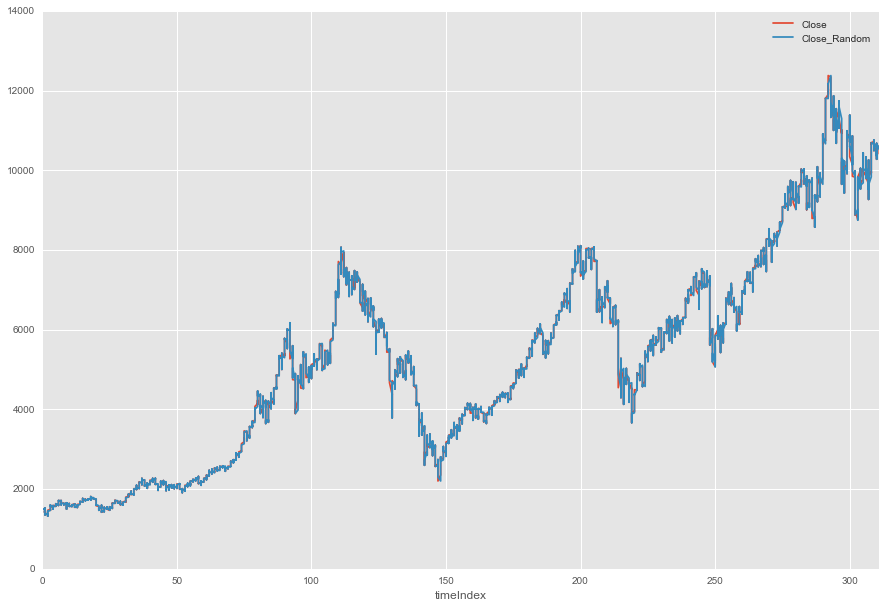

In [153]:

df.plot(kind="line", x="timeIndex", y = ["Close","Close_Random"])

In [154]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(df.Close_Random, df.Close)
model_random_RMSE

79.974914823309405

In [155]:
dfResults.loc[2,"Model"] = "Random"
dfResults.loc[2,"Forecast"] = np.exp(df.Natural_Log_Shift1[-1])
dfResults.loc[2,"RMSE"] = model_random_RMSE
dfResults.head()

Model     Forecast     RMSE
0    Mean      4555.54  2690.45
1  Linear  1.12972e+19  1282.51
2  Random      10523.1  79.9749

In [156]:
df.plot(kind="line", x="timeIndex", y = ["Close", "closing_Mean", "priceLinear", "Close_Random"])

### Eliminating Trend and Seasonality

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

1. Differencing – taking the differece with a particular time lag
1. Decomposition – modeling both trend and seasonality and removing them from the model.

**Differencing**

One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. First order differencing can be done in Pandas as:

The first thing we want to do is take a first difference of the data.In other words, subtract the previous value t-1 from the current value t to get the difference d(t). This should help to eliminate the overall trend from the data.

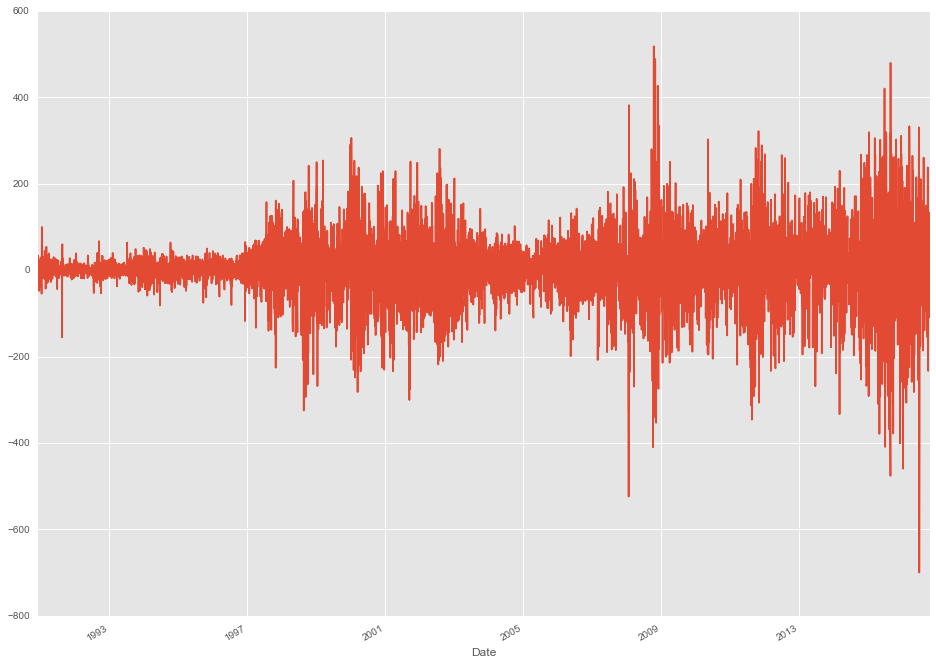

In [186]:
df['First Difference'] = df['Close'] - df['Close'].shift(1)  
df['First Difference'].plot(figsize=(16, 12))  

The data no longer appears to be trending up over time and is instead centered around 0. There's another problem though. Look at the variance. It's very small early on and steadily increases over time. This is a sign that the data is not only non-stationary but also exponentially increasing.

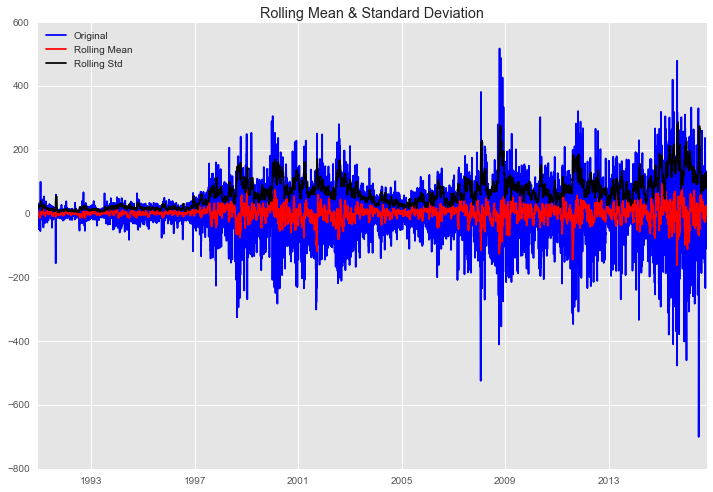

Results of Dickey-Fuller Test:
Test Statistic                  -38.278702
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    6549.000000
Critical Value (1%)              -3.431349
Critical Value (5%)              -2.861981
Critical Value (10%)             -2.567005
dtype: float64


In [187]:
test_stationarity(df['First Difference'].dropna(inplace=False))

We can see that the mean and std variations have small variations with time. Also, the Dickey-Fuller test statistic is less than the 1% critical value, thus the TS is stationary with 99% confidence.

So that gives us the original closing price with a log transform applied to "flatten" the data from an exponential curve to a linear curve.

We still need to take the first difference though so let's calculate that from the logged series.

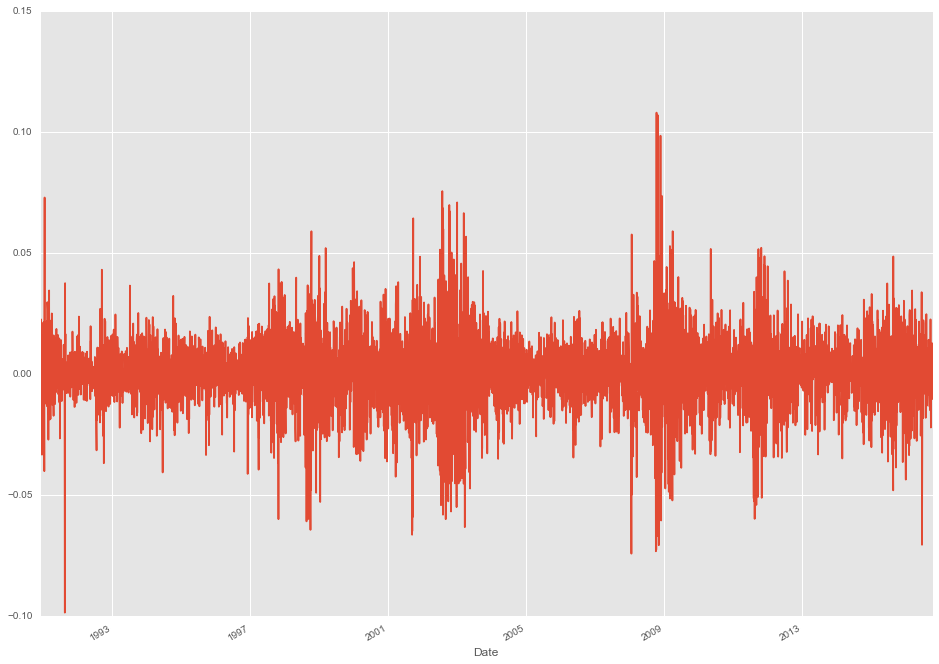

In [192]:
df['Logged First Difference'] = df['Natural_Log'] - df['Natural_Log'].shift()  
df['Logged First Difference'].plot(figsize=(16, 12))  

Much better! We now have a stationary time series model of daily changes to the DAX index. 

Now let's create some lag variables y(t-1), y(t-2) etc. and examine their relationship to y(t). We'll look at 1 and 2-day lags along with weekly and monthly lags to look for "seasonal" effects.

In [193]:
df['Lag 1'] = df['Logged First Difference'].shift()  
df['Lag 2'] = df['Logged First Difference'].shift(2)  
df['Lag 5'] = df['Logged First Difference'].shift(5)  
df['Lag 30'] = df['Logged First Difference'].shift(30)  

One interesting visual way to evaluate the relationship between lagged variables is to do a scatter plot of the original variable vs. the lagged variable and see where the distribution lies. We can do this with a joint plot using the seaborn package.

In [195]:
sns.jointplot('Logged First Difference', 'Lag 1', df, kind='reg', size=13) 

Notice how tightly packed the mass is around 0. It also appears to be pretty evenly distributed - the marginal distributions on both axes are roughly normal. This seems to indicate that knowing the index value one day doesn't tell us much about what it will do the next day.




### Decomposing

This is a technique that attempts to break down a time series into trend, seasonal, and residual factors. Statsmodels comes with a decompose function out of the box.

In [207]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Natural_Log'], model='additive', freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df['Natural_Log'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Since we don't see any real cycle in the data, the visualization is not that effective in this case. For data where this is a strong seasonal pattern though it can be very useful. The folling instance, for example, is a sample from the statsmodels documentation showing CO2 emissions data over time.

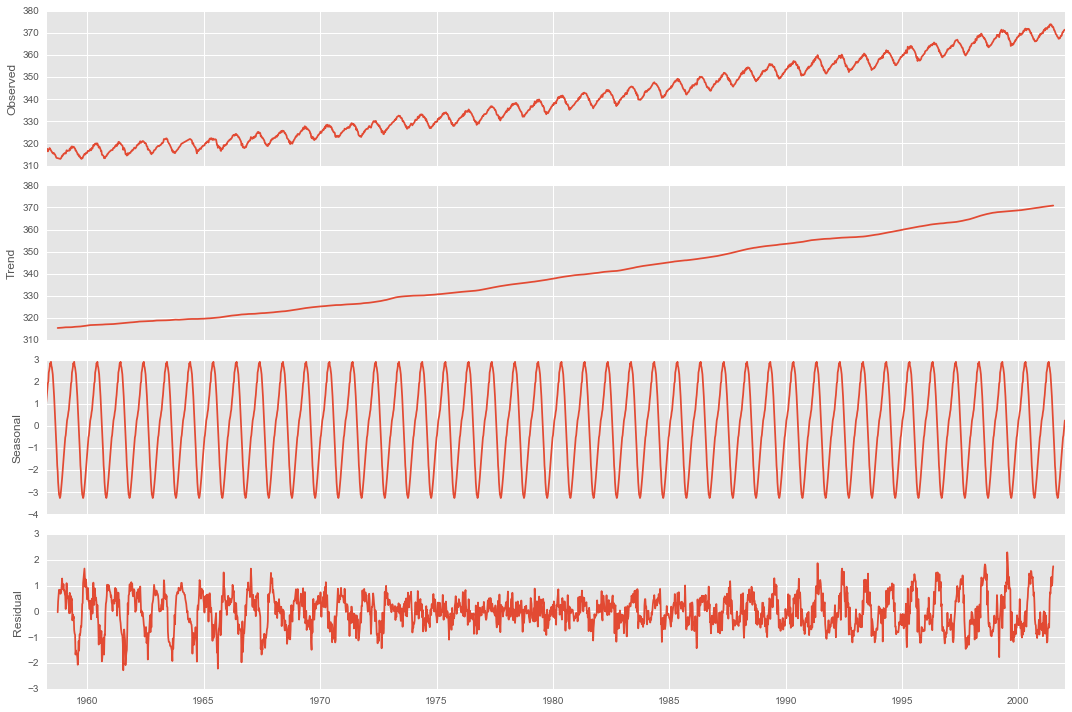

In [208]:
co2_data = sm.datasets.co2.load_pandas().data  
co2_data.co2.interpolate(inplace=True)  
result = sm.tsa.seasonal_decompose(co2_data.co2)  
fig = plt.figure()  
fig = result.plot()  

The decomposition is much more useful in this case. There are three clearly distinct components to the time series - a trend line, a seasonal adjustment, and residual values. Each of these would need to be accounted for and modeled appropriately.

##### Going back to our stock data

We can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

In [209]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Results of Dickey-Fuller Test:
Test Statistic                  -20.655432
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    6491.000000
Critical Value (1%)              -3.431358
Critical Value (5%)              -2.861985
Critical Value (10%)             -2.567007
dtype: float64


The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results. Also, you should note that converting the residuals into original values for future data in not very intuitive in this case.

In [210]:
df["Close_Decomp"] = np.exp(trend + seasonal)

In [212]:
# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(df["Close_Decomp"], df['Natural_Log'])
model_Decomp_RMSE

5841.4626864178363

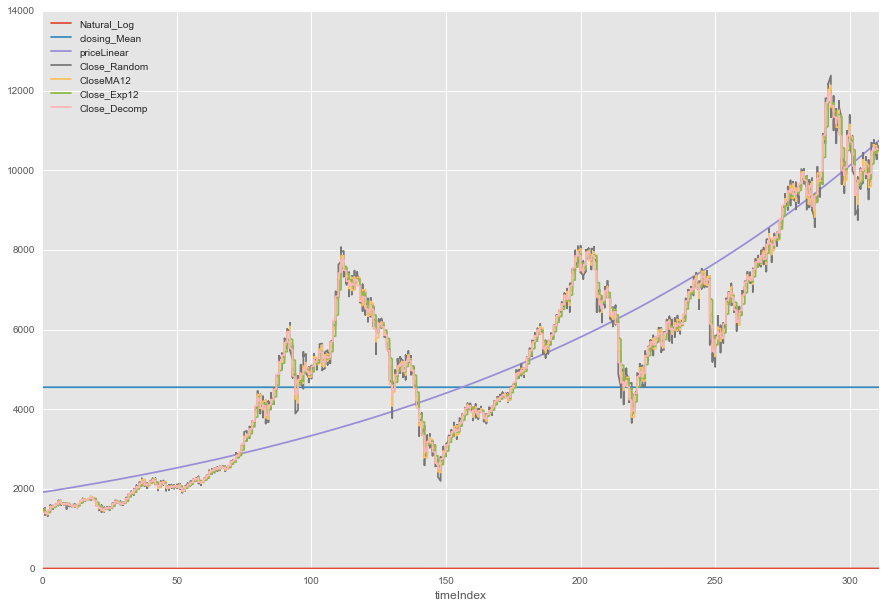

In [213]:
df.plot(kind="line", x="timeIndex", y = ["Natural_Log", "closing_Mean", "priceLinear",
                                             "Close_Random", "CloseMA12","Close_Exp12","Close_Decomp"])

### Forecasting a Time Series

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

**Auto Regressive Models - AR(p)**
In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.
Thus an autoregressive model of order (p) can be written as
$$ y_t = c + m_1y_{t-1} + m_2y_{t-2} + m_3y_{t-3} + .. \\$$
Random walk model is an AR(1) model with $$m_1=1, c = 0\\$$ Random walk model with drift model $$m_1=1, c \not= 0\\$$
We normally restrict autoregressive models to stationary data, and then some constraints on the values of the parameters are required.

For an AR(1) model: $$ −1

**Moving Average Model - MA(q)**

Rather than use past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.
$$ y_t=c+e_t+l_1 e_{t−1}+l_2 e_{t−2} + ... + l_q e_{t-q} \\$$
where e is white noise. We refer to this as an MA(q) model. Of course, we do not observe the values of e(t), so it is not really regression in the usual sense.
Notice that each value of y(t) can be thought of as a weighted moving average of the past few forecast errors. However, moving average models should not be confused with moving average smoothing. A moving average model is used for forecasting future values while moving average smoothing is used for estimating the trend-cycle of past values.

**ARIMA Model**

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average model (“integration” in this context is the reverse of differencing). The full model can be written as

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for y(t) will be y(t-1)….y(t-5).

Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for y(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

It probably comes as no surprise that there's very little correlation between the change in value from one day to the next. Although I didn't plot them out here, the other lagged variables that we created above show similar results. 

There could be a relationship to other lag steps that we haven't tried, but it's impractical to test every possible lag value manually. Fortunately there is a class of functions that can systematically do this for us.


**Autocorrelation Function (ACF): **It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

**Partial Autocorrelation Function (PACF):** This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In MA model, noise / shock quickly vanishes with time. The AR model has a much lasting effect of the shock.

In [225]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

lag_correlations = acf(df['Logged First Difference'].iloc[1:] , nlags = 40)  
lag_partial_correlations = pacf(df['Logged First Difference'].iloc[1:] , nlags = 40 , method ='ols')  

In [226]:
lag_correlations

array([  1.00000000e+00,  -5.24169559e-04,  -2.02943242e-02,
        -3.49790914e-02,   2.80062174e-02,  -3.56828318e-02,
        -1.42692509e-02,  -9.18146163e-03,   1.75356847e-02,
        -9.17247108e-03,  -7.76498926e-03,   2.66937139e-02,
        -5.74618219e-03,  -9.12409893e-03,   1.94491923e-02,
         4.08372509e-03,   8.76930394e-03,   4.87142552e-03,
        -2.30554899e-02,  -8.74411933e-03,   2.77662465e-02,
        -1.03140721e-02,  -2.03888610e-03,  -1.87534869e-03,
         6.03899603e-03,   1.80144916e-02,   9.61169940e-03,
        -2.28741998e-02,  -3.29158526e-04,   3.62320291e-02,
         1.55858040e-02,  -1.49101953e-02,   1.30399094e-02,
        -5.11743968e-03,  -3.30440153e-02,  -3.45369426e-02,
         1.36600911e-02,  -1.51795335e-02,   6.14366612e-03,
         2.40761410e-03,   5.23407217e-02])

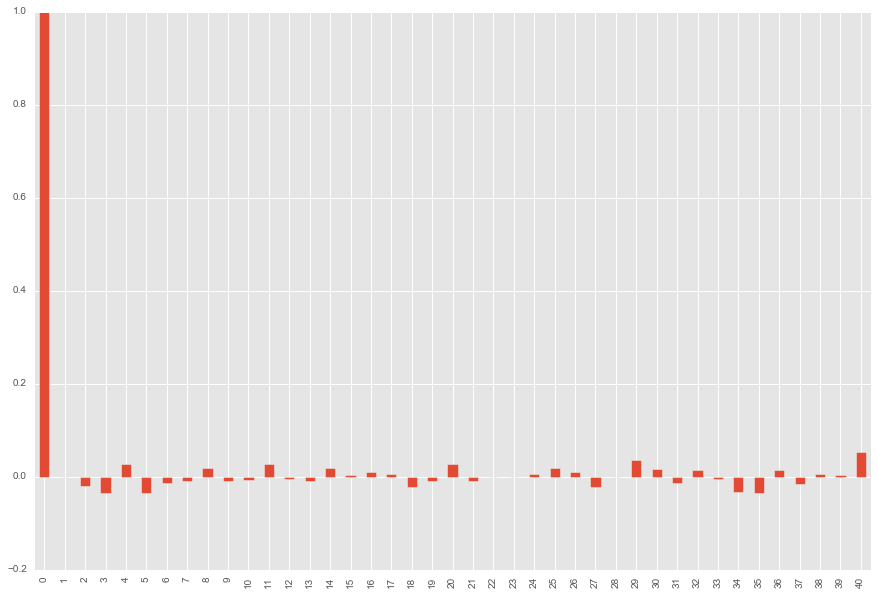

In [228]:
ACF = pd.Series(lag_correlations)
ACF.plot(kind = "bar")

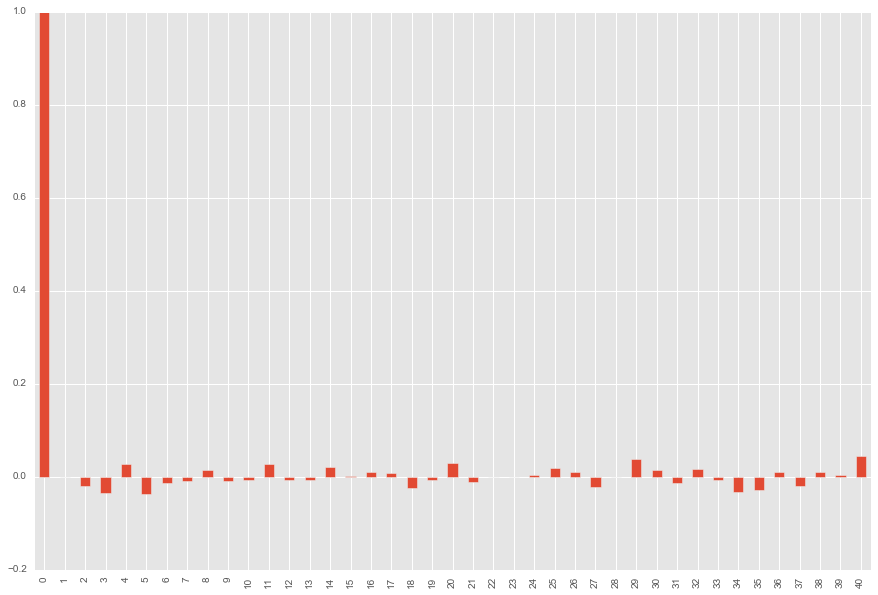

In [229]:
PACF = pd.Series(lag_partial_correlations)
PACF.plot(kind = "bar")

#### Plot the ACF and PACF charts and find the optimal parameters
To determine the tuning parameters of the model by looking at the autocorrelation and partial autocorrelation graphs. There are many rules and best practices about how to select the appropriate AR, MA, SAR, and MAR terms for the model. The chart below provides a brief guide on how to read the autocorrelation and partial autocorrelation graphs to select the proper terms. The big issue as with all models is that you don’t want to overfit your model to the data by using too many [terms](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/).

Below are the ACF and PACF charts for the seasonal first difference values (hence why I’m taking the data from the 13th instance on).

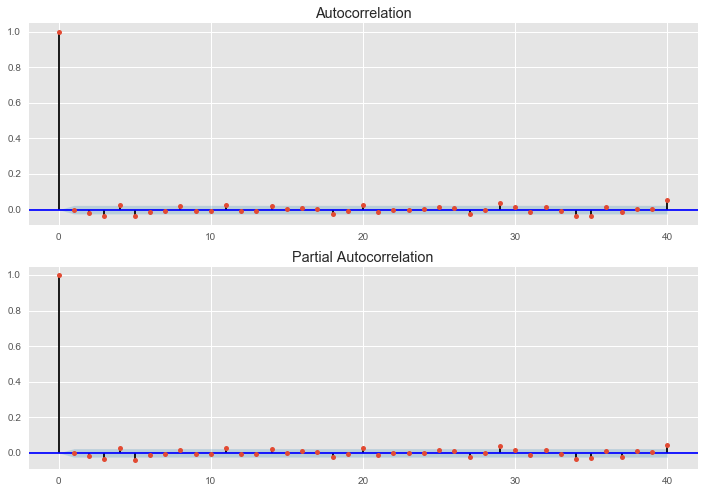

In [230]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Logged First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Logged First Difference'].iloc[13:], lags=40, ax=ax2)

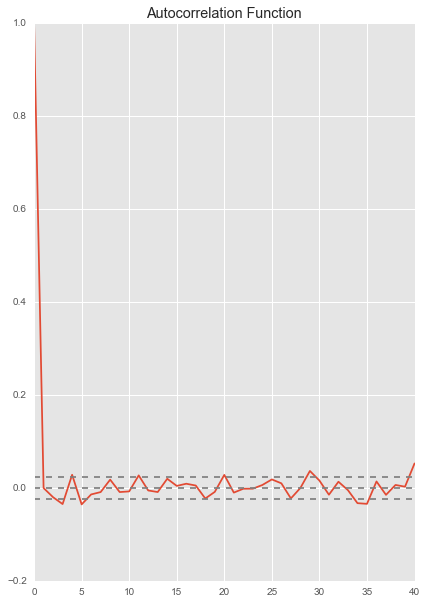

In [232]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_correlations)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df['Logged First Difference'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['Logged First Difference'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

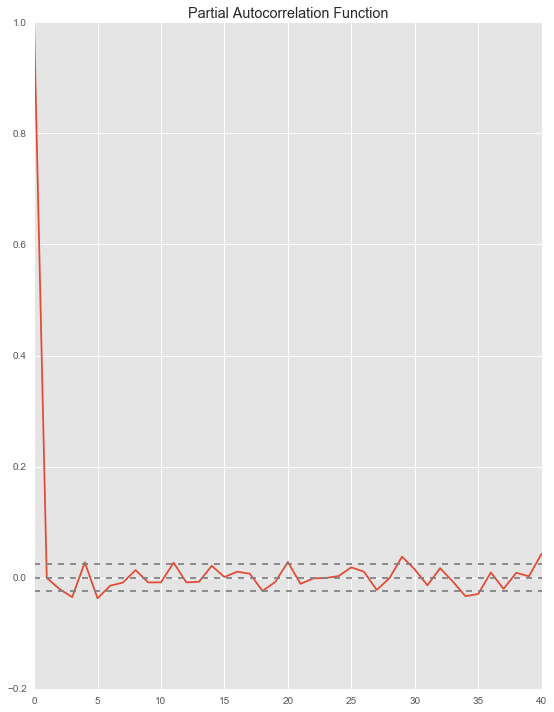

In [233]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_partial_correlations)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df['Logged First Difference'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['Logged First Difference'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p= 0
q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q= 0.

The auto-correlation and partial-autocorrelation results are very close to each other . What this shows is that there is no significant (> 0.2) correlation between the value at time t and at any time prior to t up to 40 steps behind. **In order words, the series is a random walk.**

#### Now, lets make 3 different ARIMA models considering individual as well as combined effects. 

I will also print the RSS for each. Please note that here RSS is for the values of residuals and not actual series.

The p,d,q values can be specified using the order argument of ARIMA which take a tuple (p,d,q). Let model the 3 cases:

In [251]:
from statsmodels.tsa.arima_model import ARIMA

#### AR Model

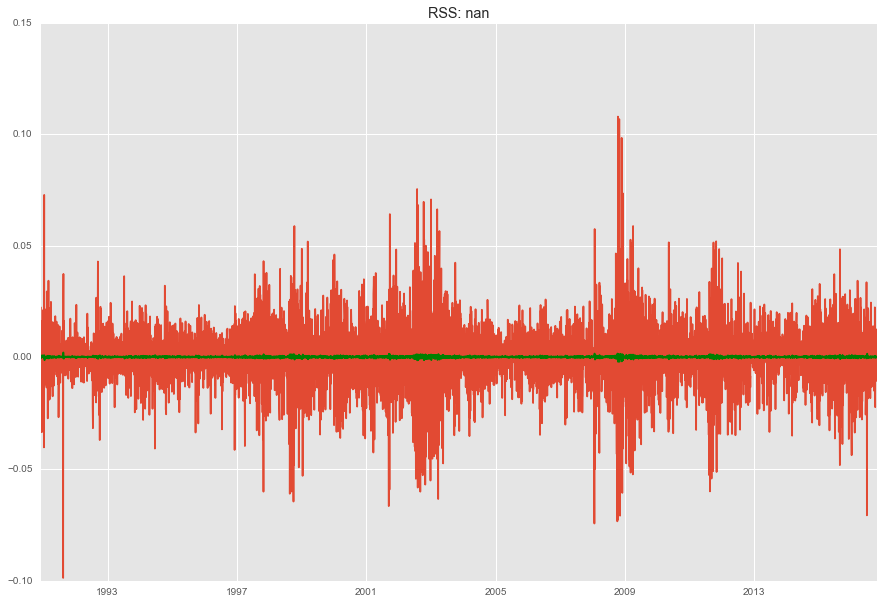

In [252]:
model = ARIMA(df['Natural_Log'], order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(df['Logged First Difference'])
plt.plot(results_AR.fittedvalues, color='green')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-df['Logged First Difference'])**2))

#### MA Model

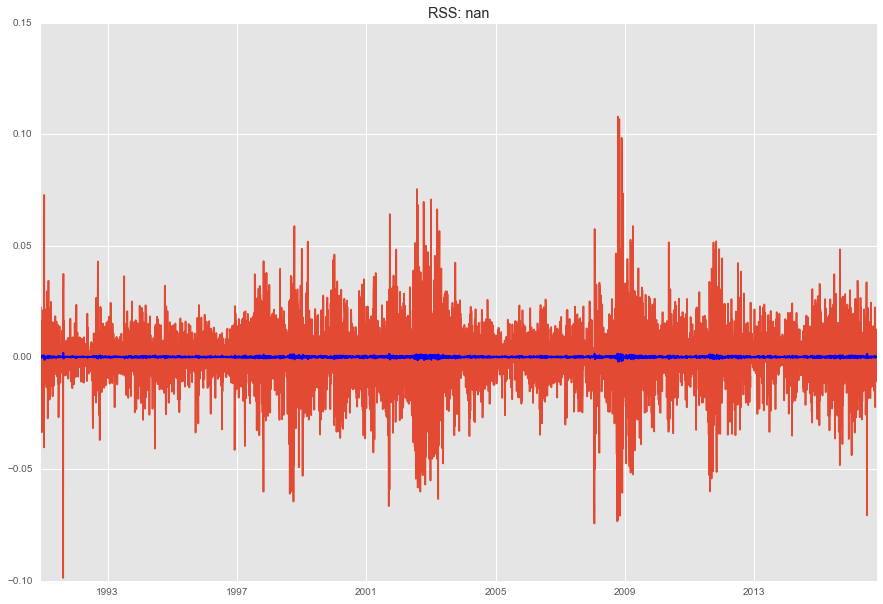

In [253]:
model = ARIMA(df['Natural_Log'], order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(df['Logged First Difference'])
plt.plot(results_MA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-df['Logged First Difference'])**2))

#### Combined Model

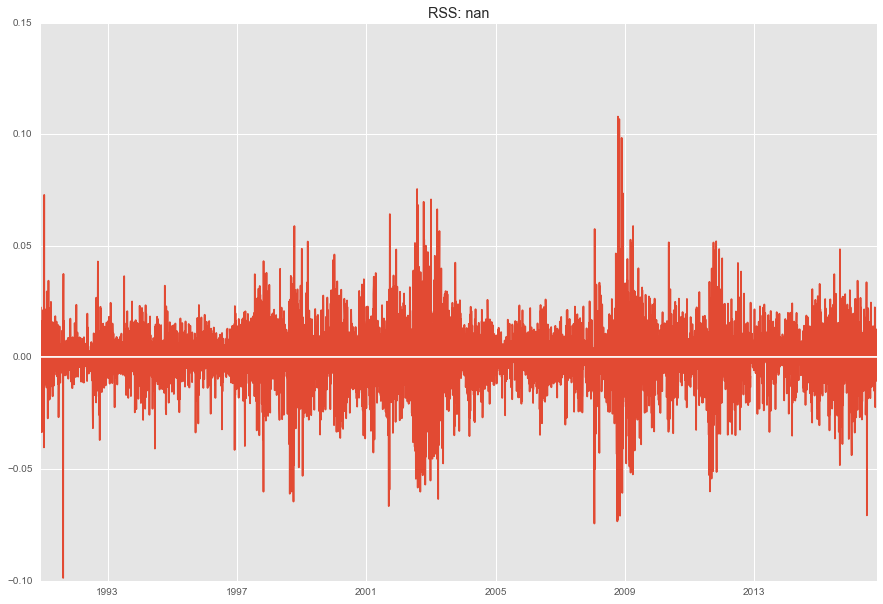

In [255]:
model = ARIMA(df['Natural_Log'], order=(0, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df['Logged First Difference'])
plt.plot(results_ARIMA.fittedvalues, color='white')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df['Logged First Difference'])**2))

Here we can see that the AR and MA models have almost the same RSS but combined is even worse.

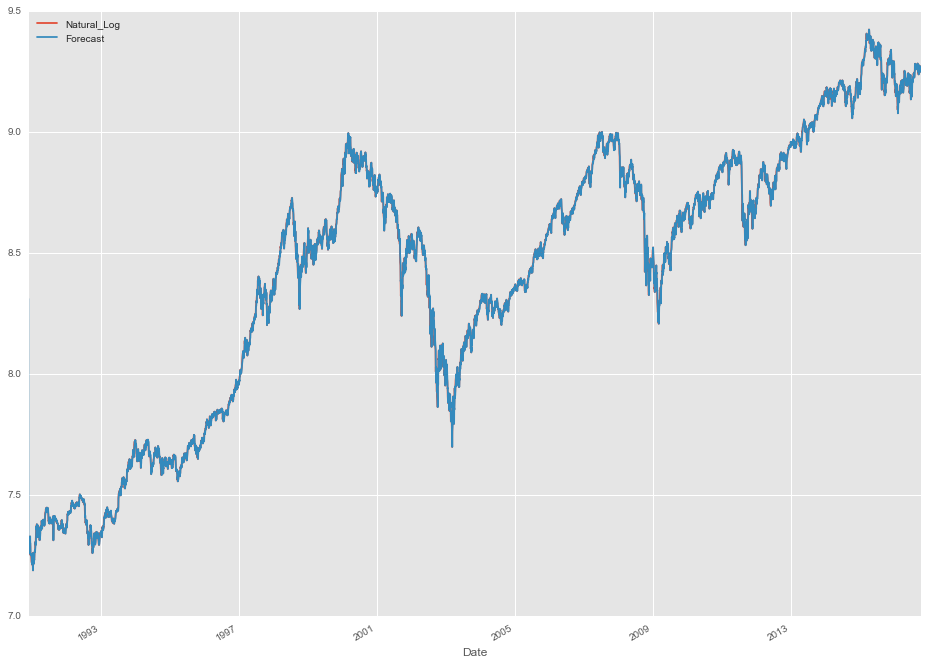

In [258]:
model = sm.tsa.ARIMA(df['Natural_Log'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
df['Forecast'] = results.fittedvalues  
df[['Natural_Log', 'Forecast']].plot(figsize=(16, 12))  

So at first glance it seems like this model is doing pretty well. But although it appears like the forecasts are really close (the lines are almost indistinguishable after all), remember that we used the un-differenced series! The index only fluctuates a small percentage day-to-day relative to the total absolute value. What we really want is to predict the first difference, or the day-to-day moves. We can either re-run the model using the differenced series, or add an "I" term to the ARIMA model (resulting in a (1, 1, 0) model) which should accomplish the same thing. Let's try using the differenced series.

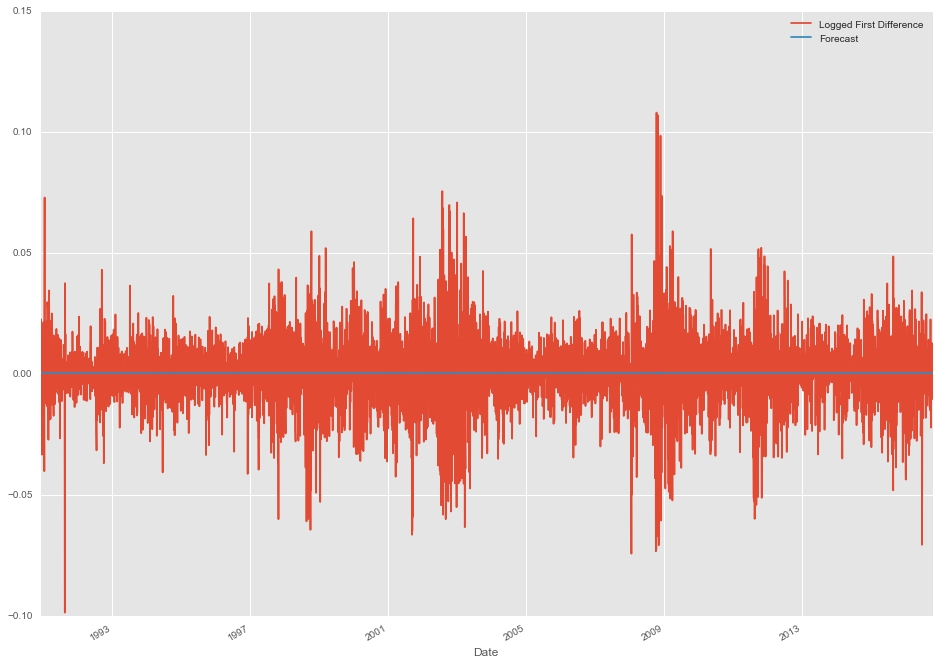

In [259]:
model = sm.tsa.ARIMA(df['Logged First Difference'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  
df['Forecast'] = results.fittedvalues  
df[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))  

It's a little hard to tell, but it appears like our forecasted changes are generally much smaller than the actual changes. It might be worth taking a closer look at a subset of the data to see what's really going on.

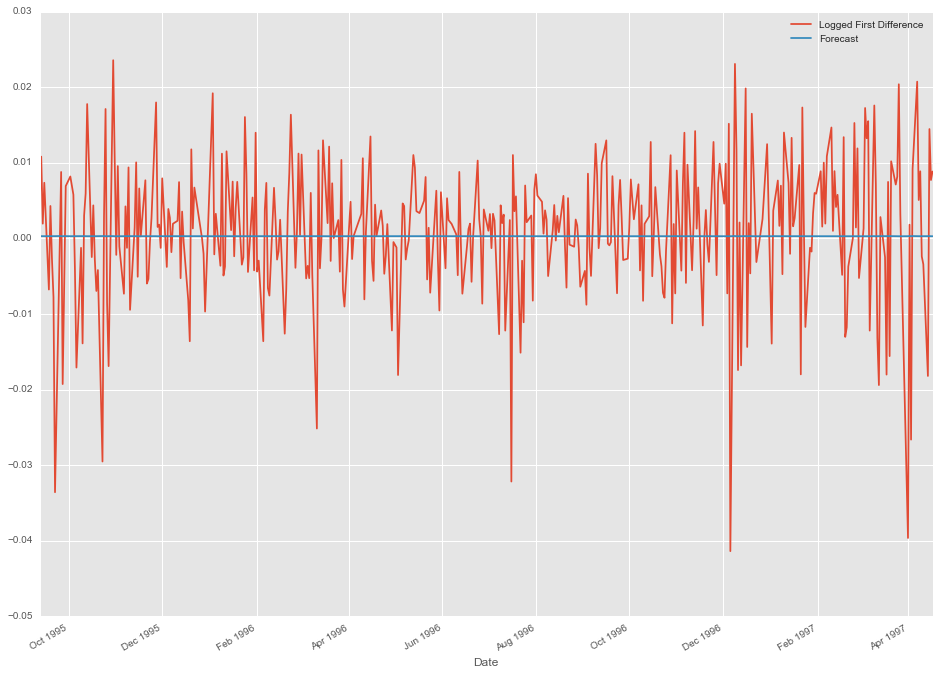

In [260]:
df[['Logged First Difference', 'Forecast']].iloc[1200:1600, :].plot(figsize=(16, 12)) 

So now it's pretty obvious that the forecast is way off. We're predicting tiny little variations relative to what is actually happening day-to-day. Again, this is more of less expected with a simple moving average model of a random walk time series. There's not enough information from the previous days to accurately forcast what's going to happen the next day.

A moving average model doesn't appear to do so well. What about an exponential smoothing model? Exponential smoothing spreads out the impact of previous values using an exponential weighting, so things that happened more recently are more impactful than things that happened a long time ago. Maybe this "smarter" form of averaging will be more accurate?

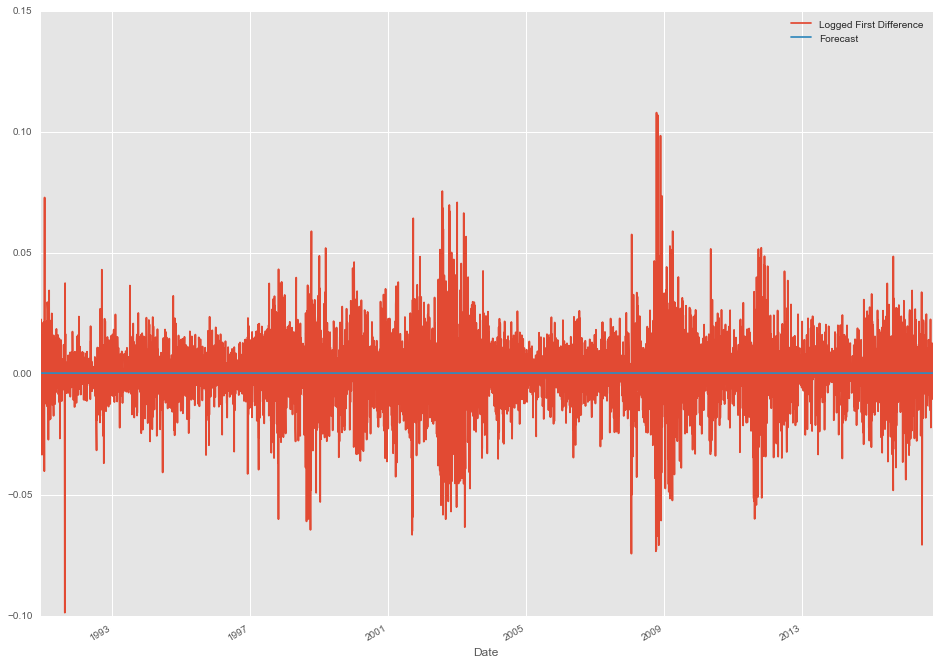

In [261]:
model = sm.tsa.ARIMA(df['Logged First Difference'].iloc[1:], order=(0, 0, 1))  
results = model.fit(disp=-1)  
df['Forecast'] = results.fittedvalues  
df[['Logged First Difference', 'Forecast']].plot(figsize=(16, 12))  

 Now, we are left with 1 last step, i.e. taking these values back to the original scale.

### Taking it back to original scale

Lets scale it back to the original values and see how well it performs there. First step would be to store the predicted results as a separate series and observe it.

In [262]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
1990-11-27    0.000302
1990-11-28    0.000302
1990-11-29    0.000302
1990-11-30    0.000302
1990-12-03    0.000302
dtype: float64


Notice that these start from ‘1990-11-27 ’ and not the first day. Why? This is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. 

The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. The cumulative sum can be found as:

In [264]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
1990-11-27    0.000302
1990-11-28    0.000603
1990-11-29    0.000905
1990-11-30    0.001206
1990-12-03    0.001508
dtype: float64


You can quickly do some back of mind calculations using previous output to check if these are correct. Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. This can be done as:

In [270]:
predictions_ARIMA_log = pd.Series(df['Natural_Log'].ix[0], index=df['Natural_Log'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head(10)

Date
1990-11-26    7.274618
1990-11-27    7.274920
1990-11-28    7.275221
1990-11-29    7.275523
1990-11-30    7.275824
1990-12-03    7.276126
1990-12-04    7.276427
1990-12-05    7.276729
1990-12-06    7.277030
1990-12-07    7.277332
dtype: float64

Here the first element is base number itself and from thereon the values cumulatively added. Last step is to take the exponent and compare with the original series. We can see there is a miniscule increase.

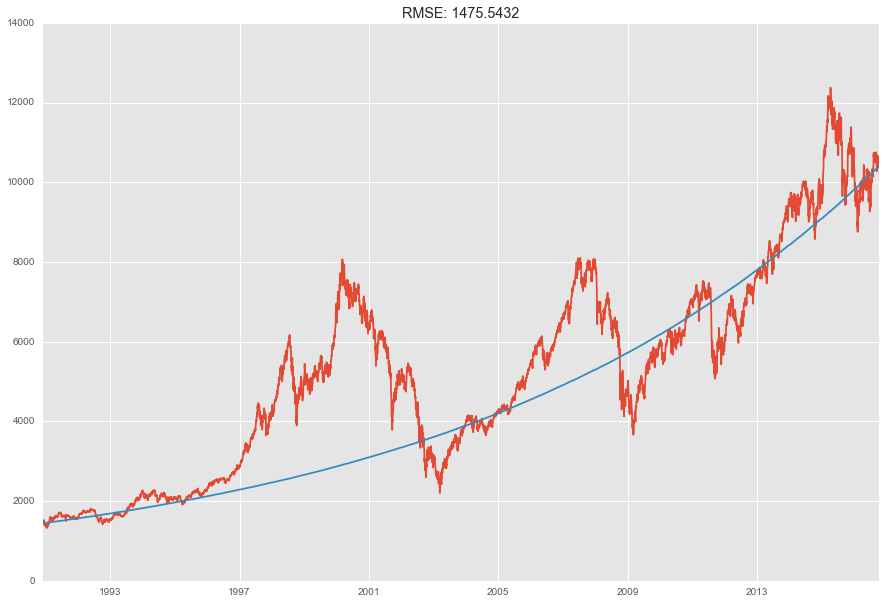

In [279]:
df['predictions_ARIMA'] = np.exp(predictions_ARIMA_log)
plt.plot(df['Close'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df['Close'])**2)/len(df['Close'])))

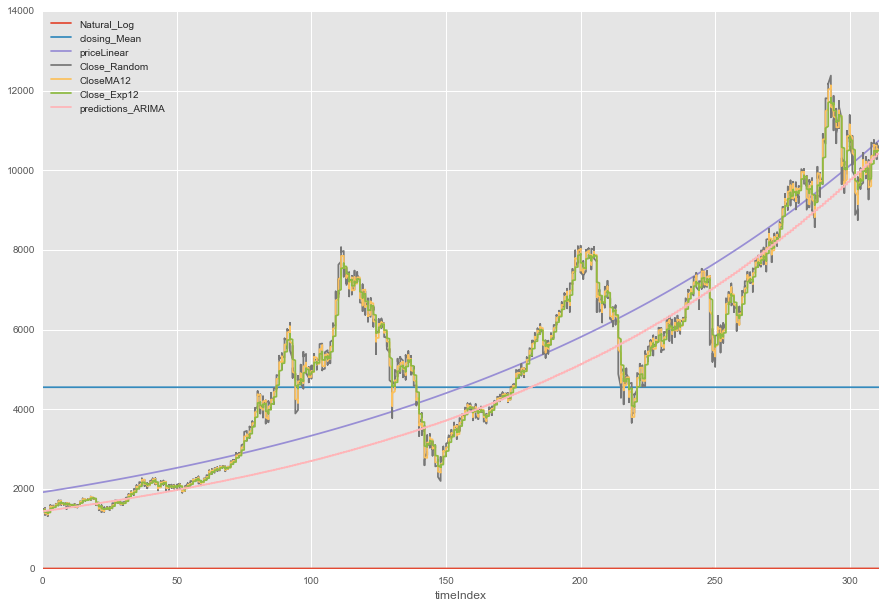

In [280]:
df.plot(kind="line", x="timeIndex", y = ["Natural_Log", "closing_Mean", "priceLinear",
                                             "Close_Random", "CloseMA12","Close_Exp12","predictions_ARIMA"])

### You can probably guess the answer...if predicting the stock market were this easy, everyone would be doing it! 



Somethings bothering you which you wish to discuss further? If you have any recommendations / suggestions or have any more doubts or queries feel to drop in your comments below.And I’ll be more than happy to discuss.